In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime, timedelta
import geoplot as gplt
import contextily 
from pysal.explore import esda   
from pysal.lib import weights
from hdbscan import HDBSCAN
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from shapely.ops import polygonize
import geoplot.crs as gcrs
from sklearn.model_selection import train_test_split

C:\Users\eduar\.conda\envs\exp\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\eduar\.conda\envs\exp\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
target = 'PROSTITUTION'

In [3]:
#directory
infolder = r"C:\Users\eduar\OneDrive\Área de Trabalho\EXPERIMENTOS DATA SCIENCE E GIS\CASE KG\infolder\eda_esda"
outfolder = r"C:\Users\eduar\OneDrive\Área de Trabalho\EXPERIMENTOS DATA SCIENCE E GIS\CASE KG\infolder\feature_engineering"
figures = r"C:\Users\eduar\OneDrive\Área de Trabalho\EXPERIMENTOS DATA SCIENCE E GIS\CASE KG\figures"

# SPLITTING THE DATASET.

In [4]:
cleaned_df = pd.read_csv(os.path.join(infolder,"cleaned.csv"))
df = cleaned_df.drop(["Unnamed: 0","Unnamed: 0.1"],axis = 1)

In [5]:
#Splitting the training and the test data.
df_train, df_test = train_test_split(df, test_size=0.3, random_state=123)

In [6]:
df_test.to_csv(os.path.join(outfolder,"df_test.csv"))

In [7]:
print(df_train.shape)
df_test.shape

(616321, 14)


(264138, 14)

# EDA

In [8]:
gdf = gpd.GeoDataFrame(
    df_train, geometry=gpd.points_from_xy(df_train.X, df_train.Y,crs ="EPSG:4326" ))

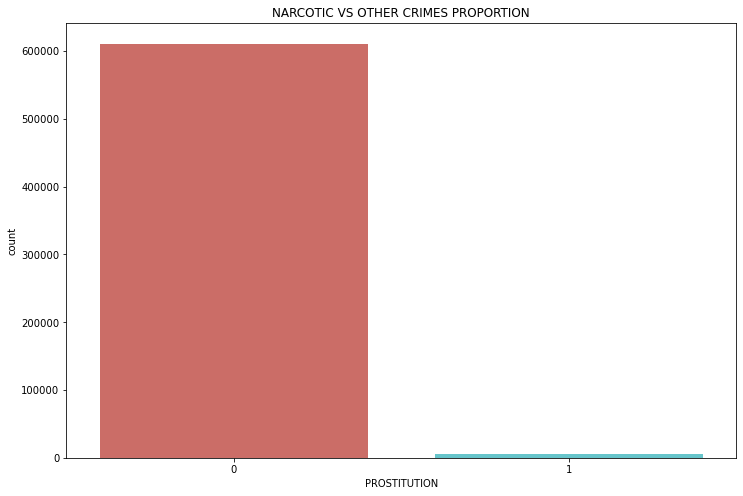

In [9]:
plt.figure(figsize=(12,8))
sns.countplot(x=target,data=gdf,palette="hls").set_title("NARCOTIC VS OTHER CRIMES PROPORTION")
plt.savefig(os.path.join(figures,"proportion.jpg"))

I WIIL DO SOME FEATURE ENGENIRING IN ADVANCE TO UNDERSTAND THE TIME DATA IN EDA.

In [10]:
def time_transformation(df_T):
    
    df_T['hour'] = pd.to_datetime(df_T['Dates']).dt.hour
    df_T['Month'] = pd.to_datetime(df_T['Dates']).dt.month
    df_T['Year'] = pd.to_datetime(df_T['Dates']).dt.year

    return df_T

In [11]:
time_transformation(gdf)

Dates        Category  \
769340  2012-07-29 22:30:00   VEHICLE THEFT   
348087  2005-08-13 21:00:00  MISSING PERSON   
782587  2013-07-10 17:35:00   LARCENY/THEFT   
866927  2008-07-09 13:00:00    NON-CRIMINAL   
655332  2008-01-25 00:43:00   DRUG/NARCOTIC   
...                     ...             ...   
192476  2003-10-13 20:55:00         ROBBERY   
17730   2009-11-13 09:00:00  SUSPICIOUS OCC   
28030   2004-10-30 07:00:00        BURGLARY   
277869  2013-05-01 12:00:00  MISSING PERSON   
773630  2011-04-04 23:12:00       VANDALISM   

                                       Descript  DayOfWeek  PdDistrict  \
769340                        STOLEN AUTOMOBILE     Sunday     TARAVAL   
348087                            MISSING ADULT   Saturday     MISSION   
782587             PETTY THEFT FROM LOCKED AUTO  Wednesday     TARAVAL   
866927                            LOST PROPERTY  Wednesday  TENDERLOIN   
655332    POSSESSION OF NARCOTICS PARAPHERNALIA     Friday    SOUTHERN   
...                                         ...        ...         ...   
192476         ROBBERY ON THE STREET WITH A GUN     Monday   INGLESIDE   
17730                     SUSPICIOUS OCCURRENCE     Friday     BAYVIEW   
28030     BURGLARY OF RESIDENCE, FORCIBLE ENTRY   Saturday     BAYVIEW   
277869                             FOUND PERSON  Wednesday     MISSION   
773630  VANDALISM OR GRAFFITI TOOLS, POSSESSION     Monday     TARAVAL   

            Resolution                         Address           X          Y  \
769340            NONE        1200 Block of PACHECO ST -122.473545  37.750573   
348087         LOCATED        1000 Block of POTRERO AV -122.406539  37.756486   
782587            NONE          300 Block of ASHTON AV -122.462206  37.723954   
866927            NONE            0 Block of POWELL ST -122.407845  37.785094   
655332  ARREST, BOOKED  MISSION ST / SOUTH VAN NESS AV -122.418619  37.773053   
...                ...                             ...         ...        ...   
192476            NONE           MUNICH ST / RUSSIA AV -122.429170  37.717763   
17730             NONE            3800 Block of 3RD ST -122.387939  37.742260   
28030             NONE         1300 Block of THOMAS AV -122.386675  37.727729   
277869            NONE    MISSION ST / CESAR CHAVEZ ST -122.418222  37.748166   
773630            NONE           ORIZABA AV / BROAD ST -122.462567  37.713151   

        PROSTITUTION                                               link  \
769340             0  http://en.wikipedia.org/wiki/Neighborhoods_in_...   
348087             0  http://www.sfgate.com/neighborhoods/sf/potrero...   
782587             0  http://en.wikipedia.org/wiki/Neighborhoods_in_...   
866927             0  http://www.sfgate.com/neighborhoods/sf/unionsq...   
655332             0       http://www.sfgate.com/neighborhoods/sf/soma/   
...              ...                                                ...   
192476             0  http://en.wikipedia.org/wiki/Excelsior_Distric...   
17730              0  http://en.wikipedia.org/wiki/Neighborhoods_in_...   
28030              0  http://en.wikipedia.org/wiki/Neighborhoods_in_...   
277869             0    http://www.sfgate.com/neighborhoods/sf/mission/   
773630             0  http://en.wikipedia.org/wiki/Neighborhoods_in_...   

                           name     area                     geometry  hour  \
769340      Golden Gate Heights  1671383  POINT (-122.47355 37.75057)    22   
348087             Potrero Hill  2345243  POINT (-122.40654 37.75649)    21   
782587                Ingleside   947442  POINT (-122.46221 37.72395)    17   
866927  Downtown / Union Square   359875  POINT (-122.40785 37.78509)    13   
655332          South of Market  3098068  POINT (-122.41862 37.77305)     0   
...                         ...      ...                          ...   ...   
192476                Excelsior  1674232  POINT (-122.42917 37.71776)    20   
17730                   Bayview  2578157  POINT (-122.38794 37

In [12]:
gdf["late_night"] = (gdf["hour"] <= 6).astype(int)
gdf["evening"] = (gdf["hour"] >= 18).astype(int)
gdf["night_time"] = gdf["late_night"] + gdf["evening"]

NOW I CREATED TWO DIFFERENT DATAFRAMES

In [13]:
df_target = gdf.loc[gdf[target] == 1]
df_other_crimes = gdf.loc[gdf[target] == 0]

In [14]:
#This lists helped me to automate the first step of EDA
cat_cols_eda = ["DayOfWeek","PdDistrict","evening","late_night","night_time"]
num_cols_eda = ["X","Y"]

In [15]:
gdf[["X","Y",target]].corr(method='spearman')

X         Y  PROSTITUTION
X             1.000000  0.147656     -0.004877
Y             0.147656  1.000000      0.021553
PROSTITUTION -0.004877  0.021553      1.000000

In [16]:
df_cramer = gdf
lista_cramer = [target,"DayOfWeek","PdDistrict","evening","late_night","night_time"]

In [17]:
label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in df_cramer[lista_cramer]:
  data_encoded[i]=label.fit_transform(df_cramer[i])

In [18]:





def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [19]:
rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)



df

PROSTITUTION  DayOfWeek  PdDistrict  evening  late_night  \
PROSTITUTION          1.00       0.00        0.01     0.00        0.00   
DayOfWeek             0.00       1.00        0.00     0.00        0.01   
PdDistrict            0.01       0.00        1.00     0.00        0.00   
evening               0.00       0.00        0.00     1.00        0.09   
late_night            0.00       0.01        0.00     0.09        1.00   
night_time            0.00       0.00        0.00     0.51        0.21   

              night_time  
PROSTITUTION        0.00  
DayOfWeek           0.00  
PdDistrict          0.00  
evening             0.51  
late_night          0.21  
night_time          1.00

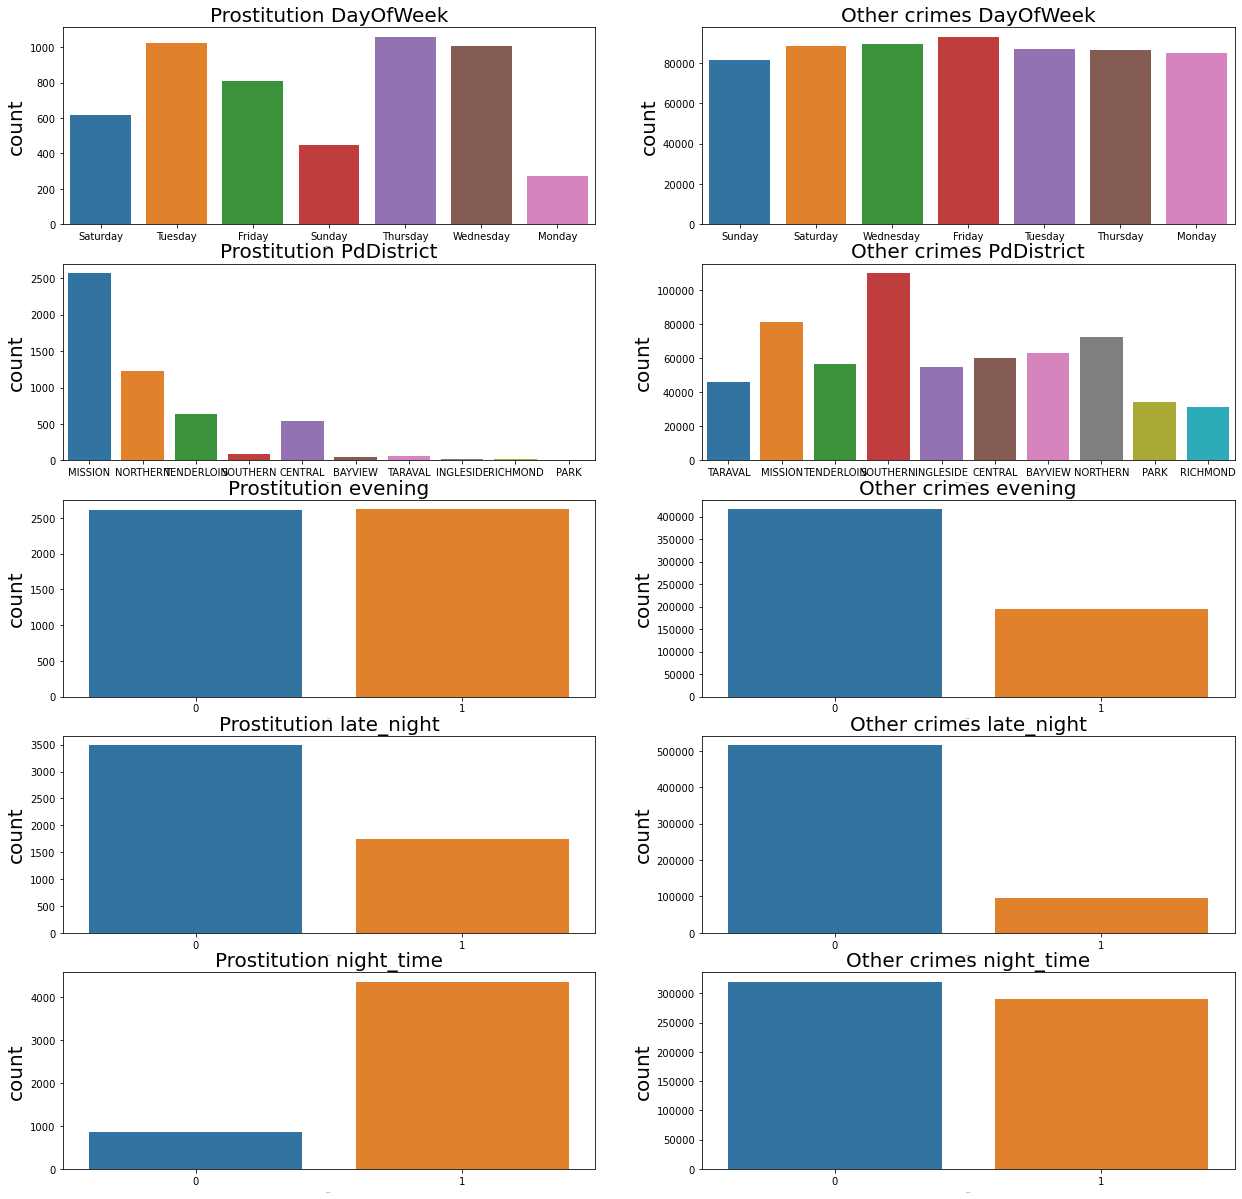

In [20]:
contagem = 0 
fig,ax = plt.subplots(len(cat_cols_eda),2, figsize=(21,21))



for x in df_target[cat_cols_eda]:
    sns.countplot(x=x,data=df_target,ax=ax[contagem,0])
    ax[contagem,0].set_title(f'Prostitution {x}',fontsize=20)
    ax[contagem,0].yaxis.label.set_size(20)
    ax[contagem,0].xaxis.label.set_size(0)
    ax[contagem,0].tick_params(axis="both",which="minor",labelsize=15,pad=3)
    sns.countplot(x=x,data=df_other_crimes,ax=ax[contagem,1])
    ax[contagem,1].set_title(f'Other crimes {x}',fontsize=20)
    ax[contagem,1].yaxis.label.set_size(20)
    ax[contagem,1].xaxis.label.set_size(0)
    ax[contagem,1].tick_params(axis="both",which="minor",labelsize=30)
    contagem += 1
    
plt.savefig(os.path.join(figures,"Categorical_Features.jpg"))

# ESDA

<GeoAxesSubplot:>

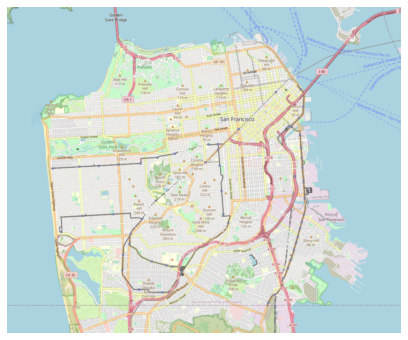

In [21]:
study_area = gpd.read_file(gplt.datasets.get_path('san_francisco'))

gplt.webmap(study_area, projection=gcrs.WebMercator())

In [22]:
gplt.datasets.get_path('nyc_boroughs')

'https://raw.githubusercontent.com/ResidentMario/geoplot-data/master/nyc-boroughs.geojson'

f, ax = plt.subplots(1, figsize=(30,30))
gdf.plot(column=target, cmap='plasma',  edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);
contextily.add_basemap(ax, 
                       crs=gdf.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()
plt.savefig(r"C:\Users\eduardovirtuoso\Desktop\estudos\CASE KG\saidas\ESDA\all_crimes_distribuition.jpg")

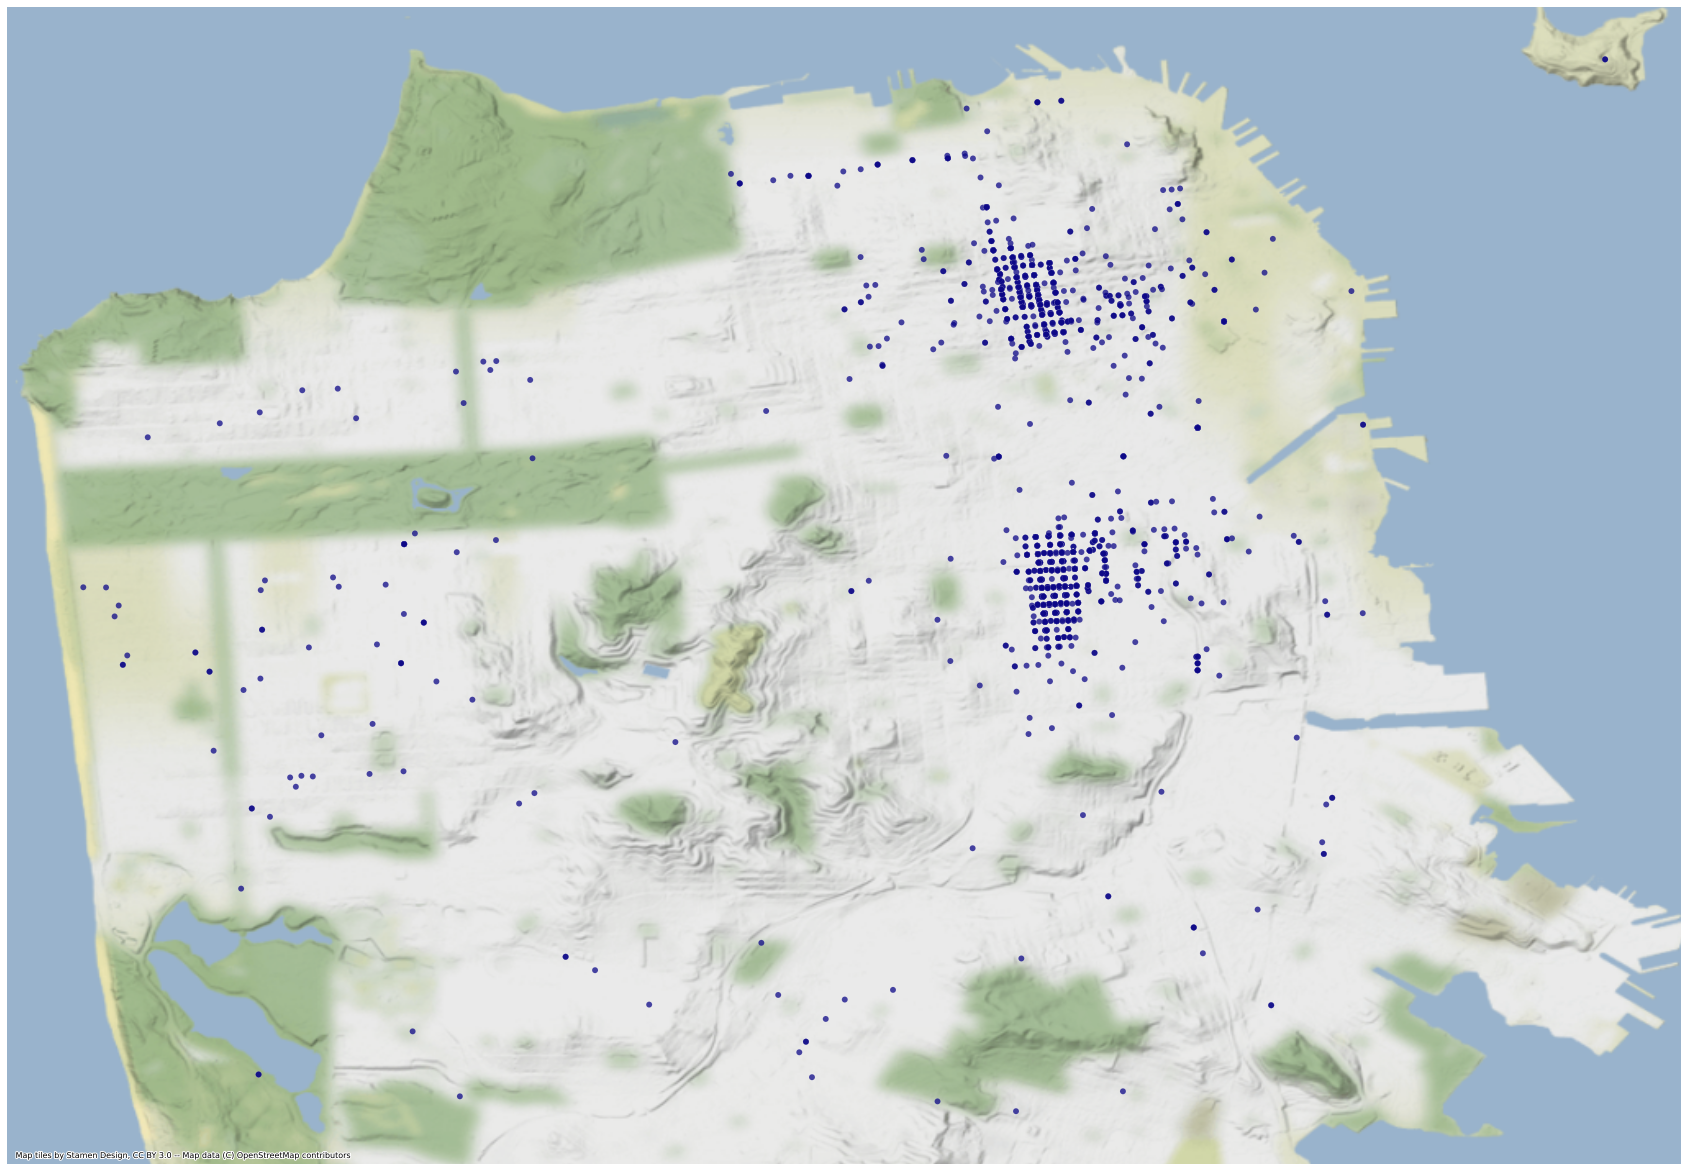

In [23]:
f, ax = plt.subplots(1, figsize=(30,30))
df_target.plot(column=target, cmap='plasma',  edgecolor='white', linewidth=0.1, alpha=0.75, legend=False,ax=ax);
contextily.add_basemap(ax, 
                       crs=df_target.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()
plt.savefig(os.path.join(figures,"distribuition.jpg"))

C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\eduar\.conda\envs\exp\lib\site-packages\seaborn\_decorators.py:36: Fut

C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:228: ShapelyDep

C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:228: ShapelyDep

C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:228: ShapelyDep

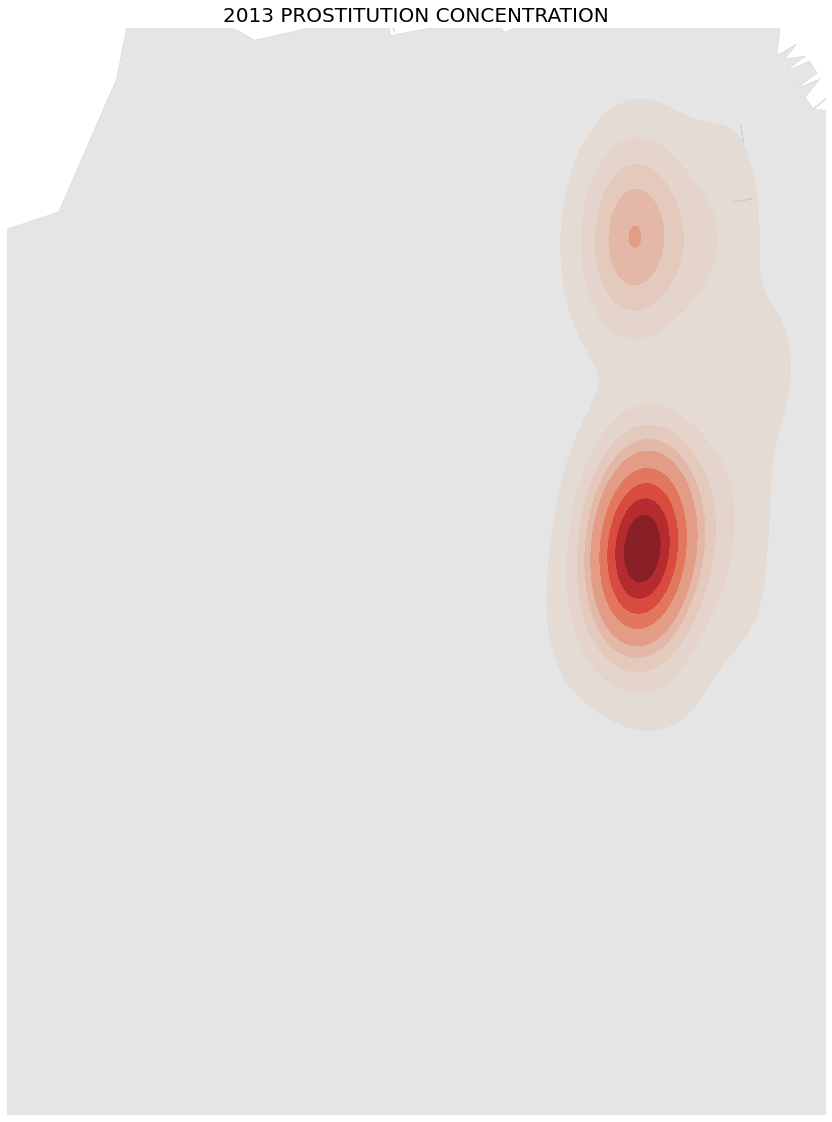

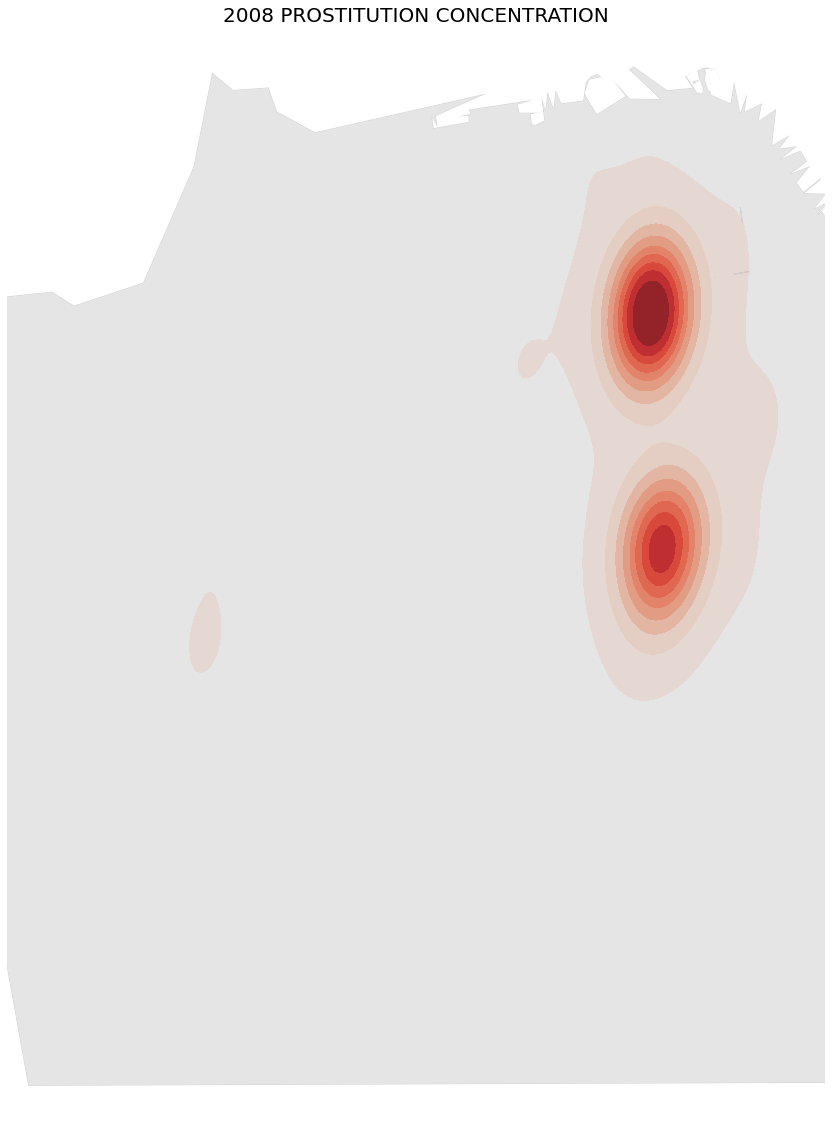

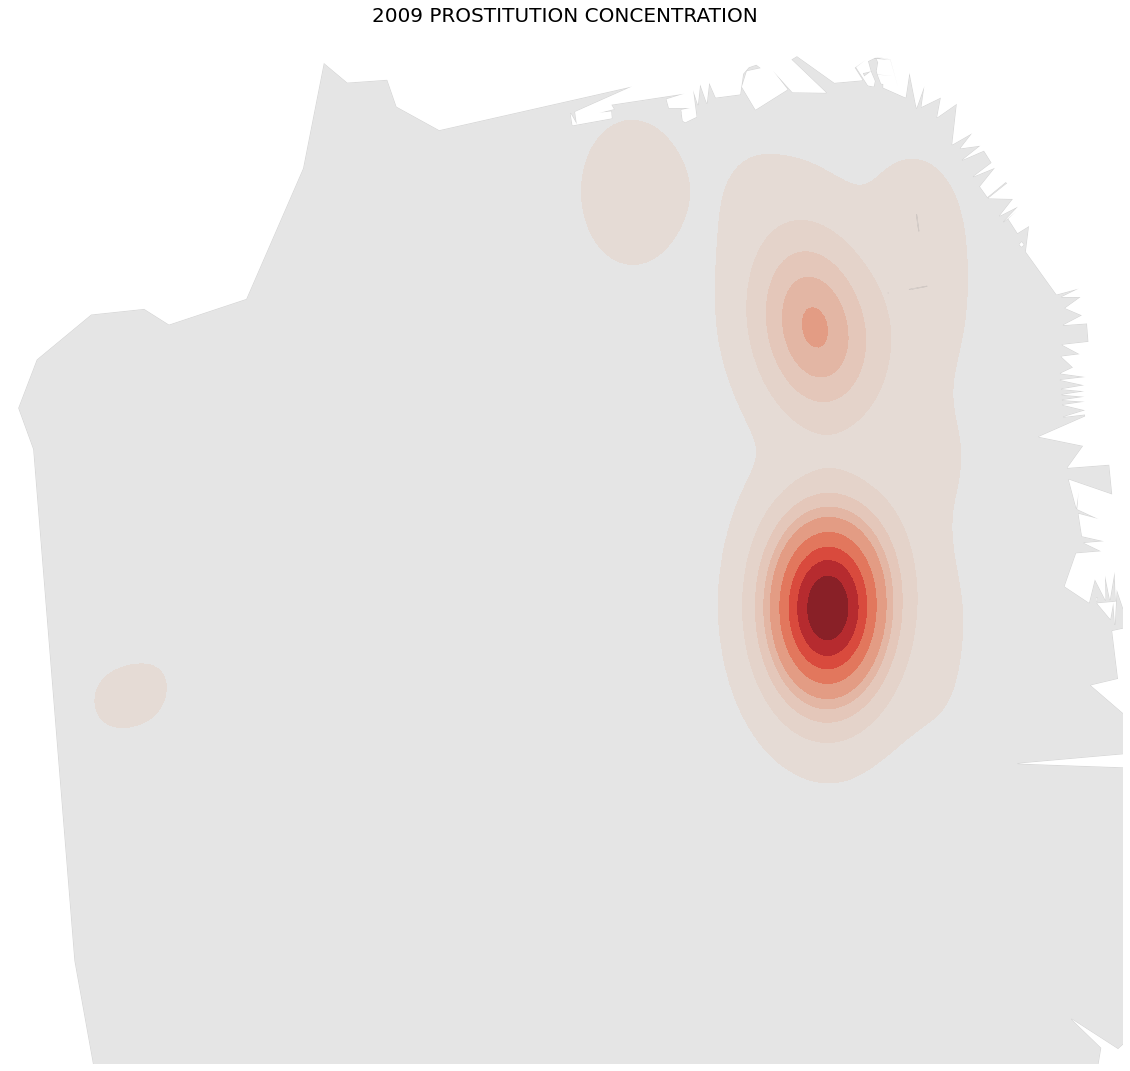

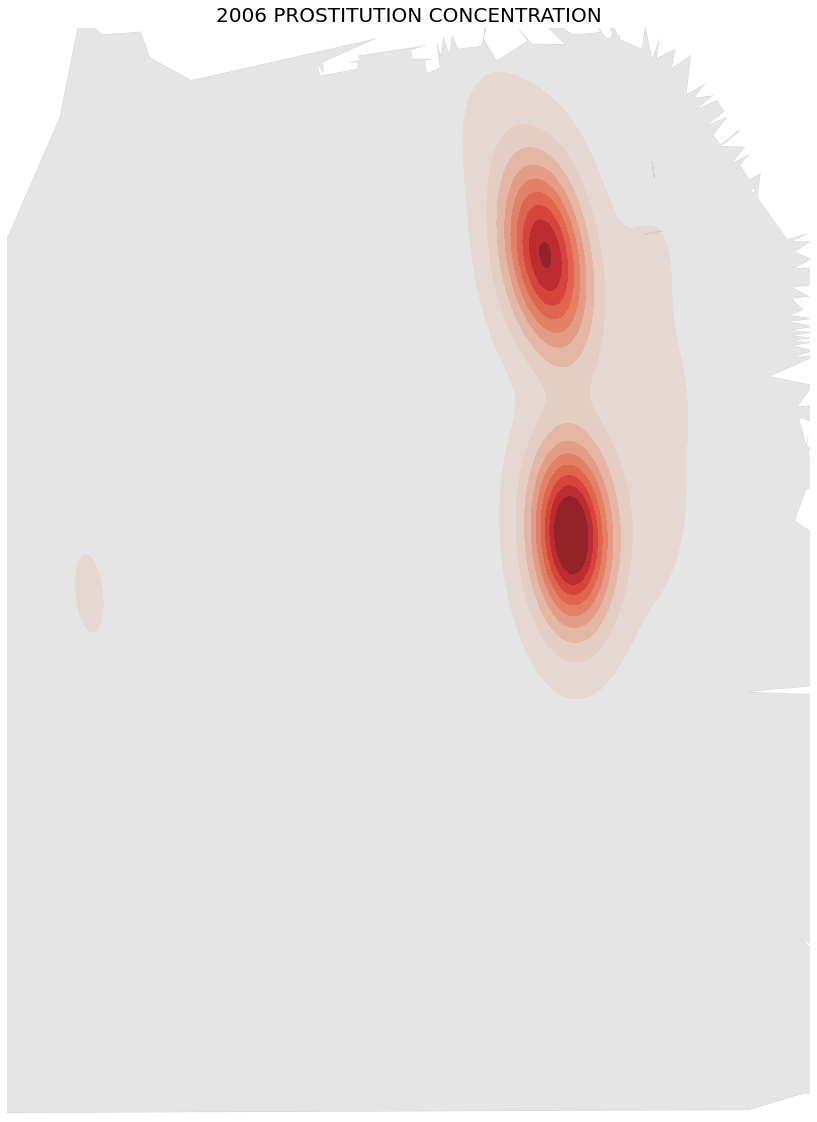

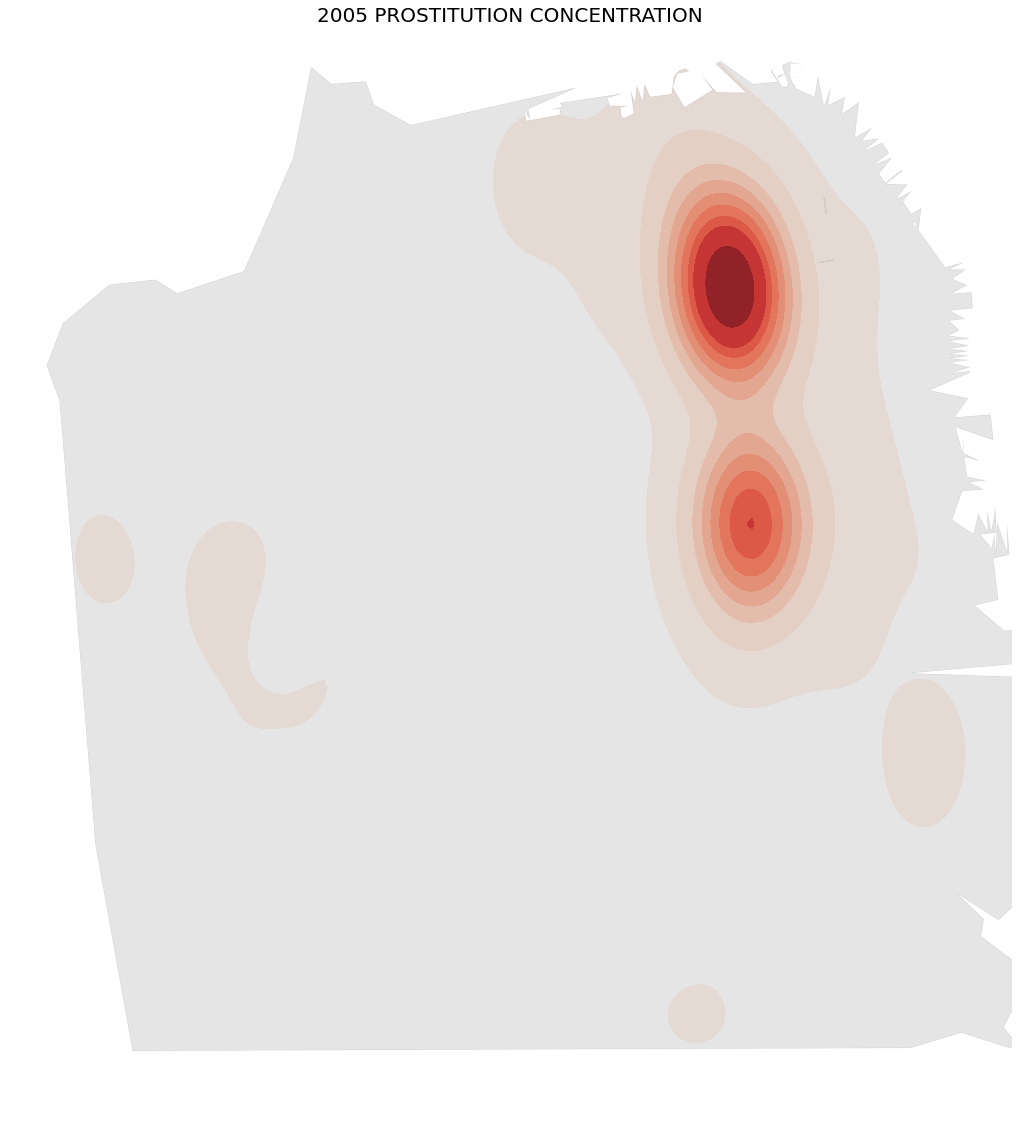

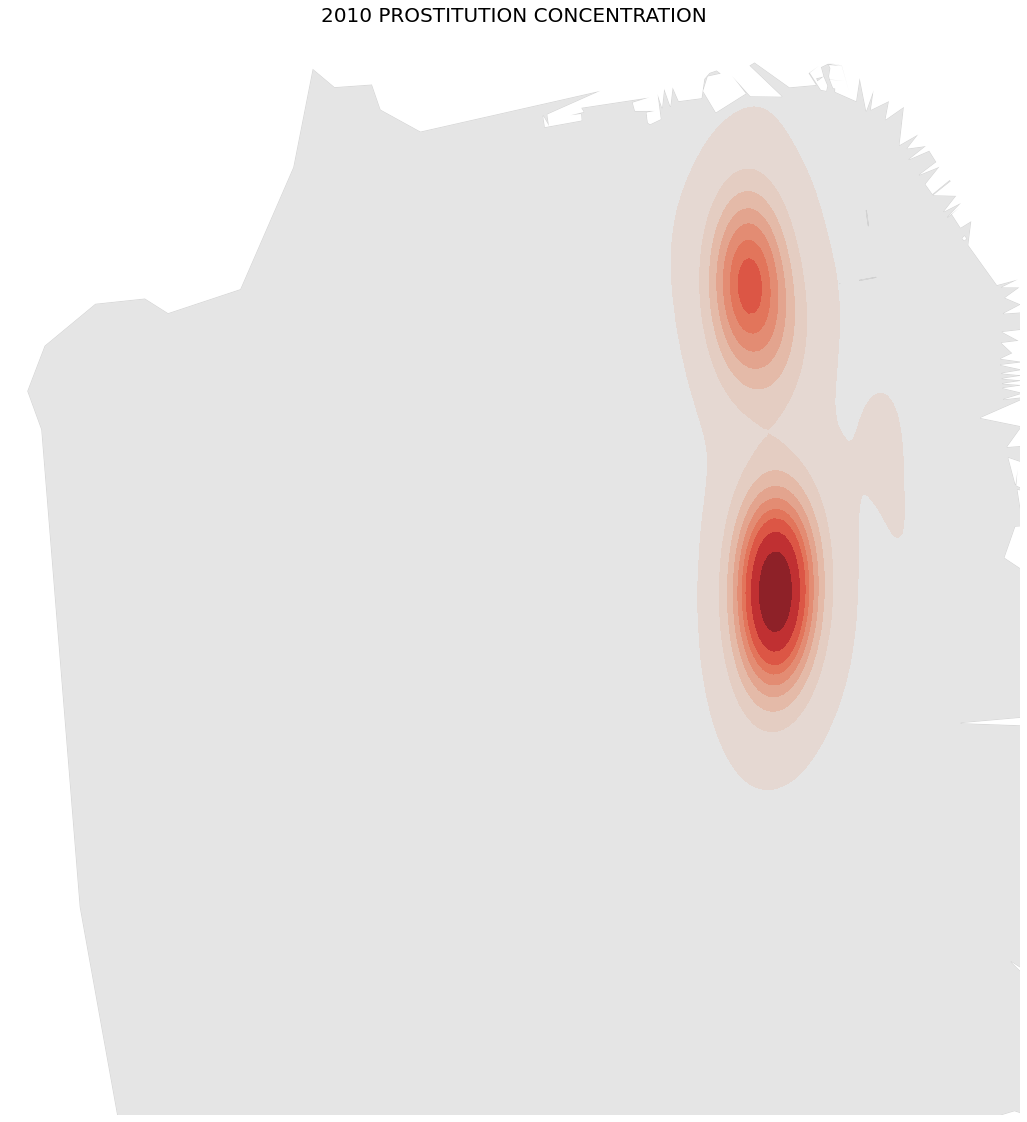

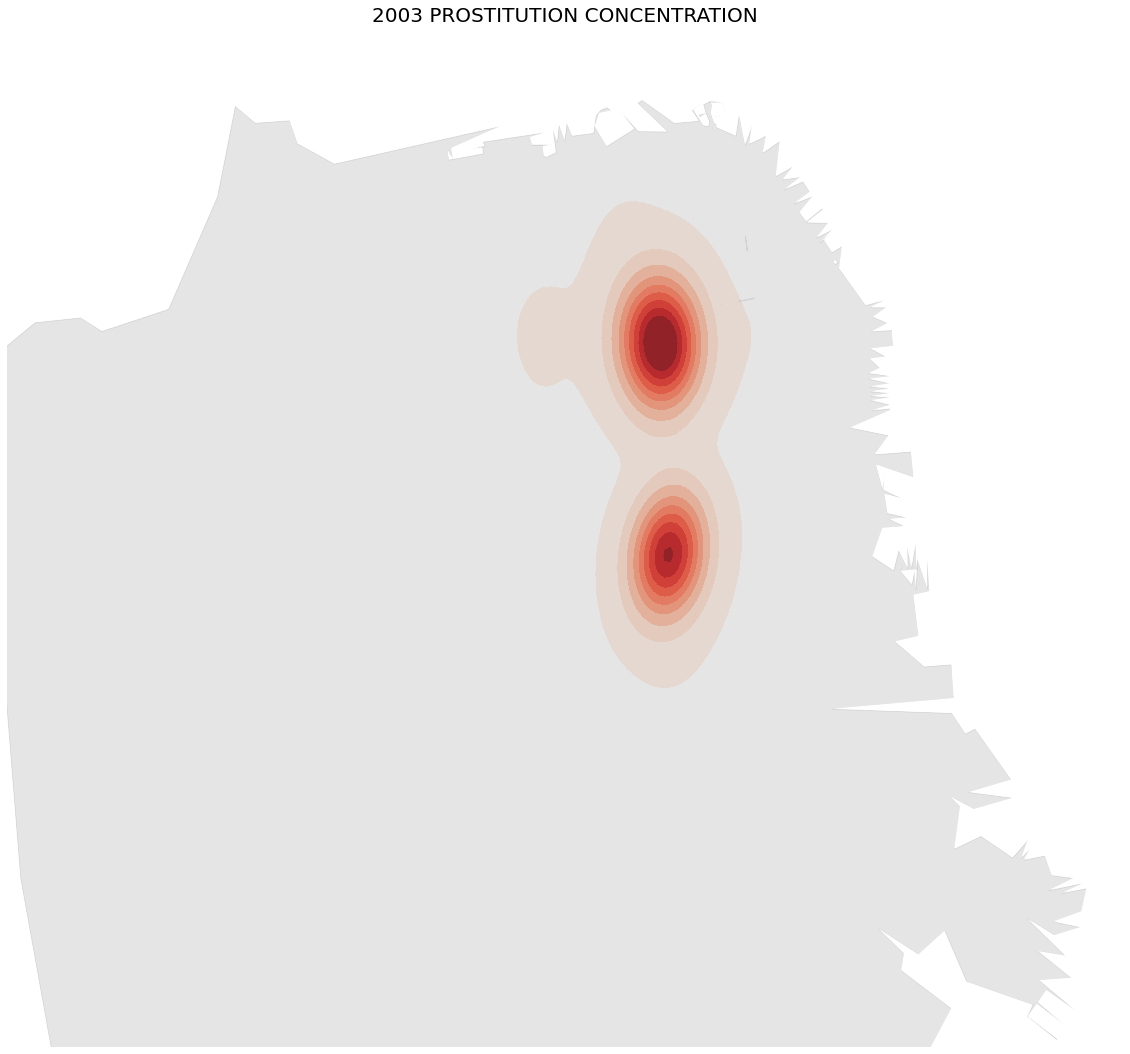

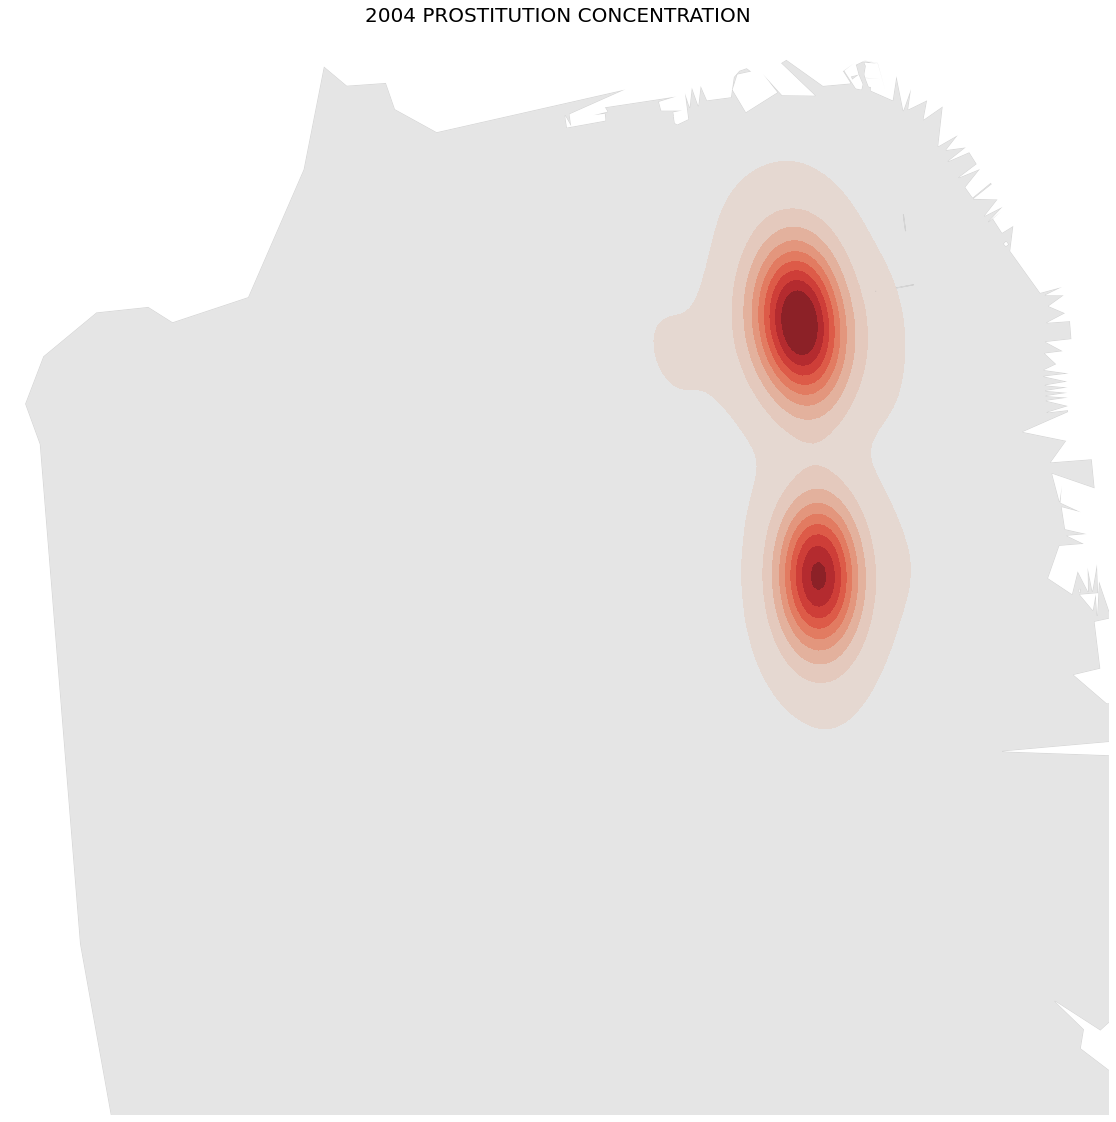

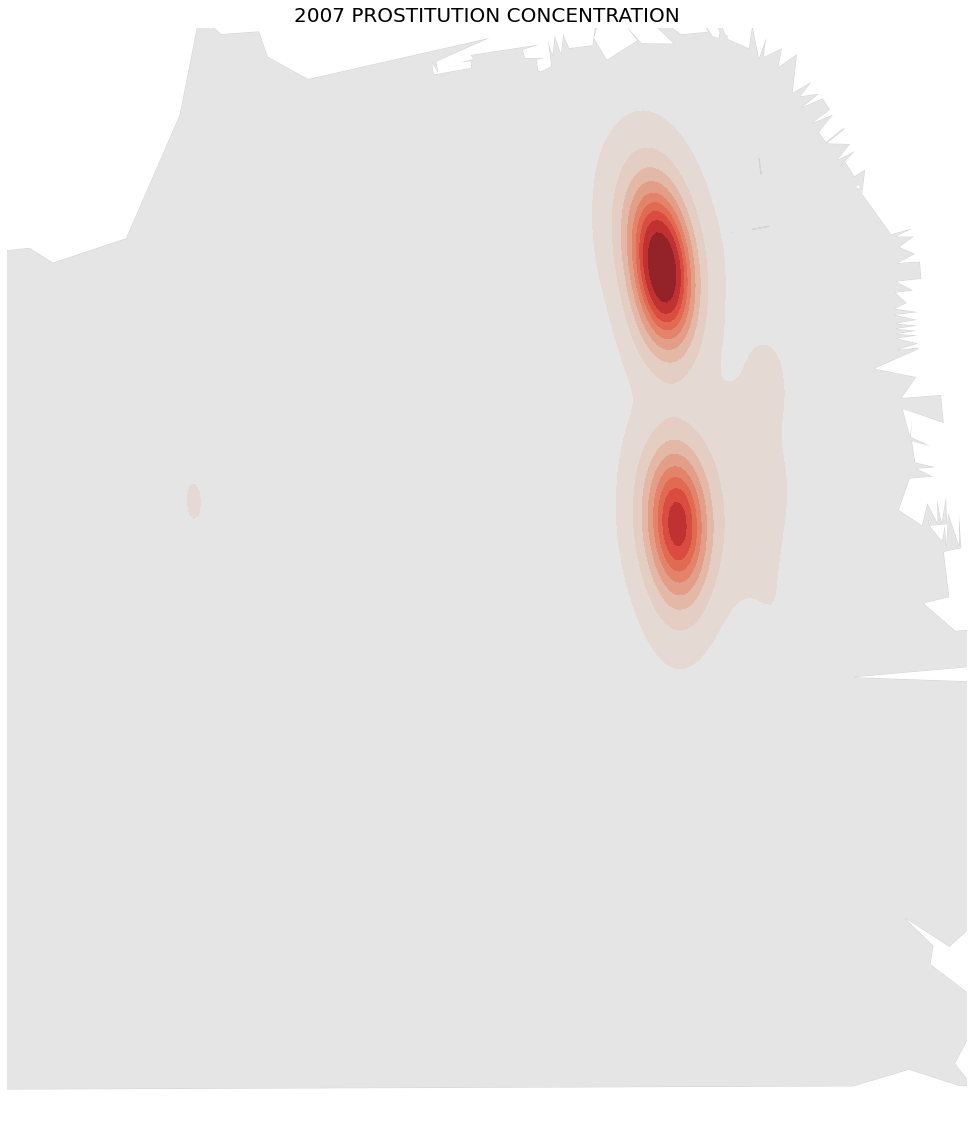

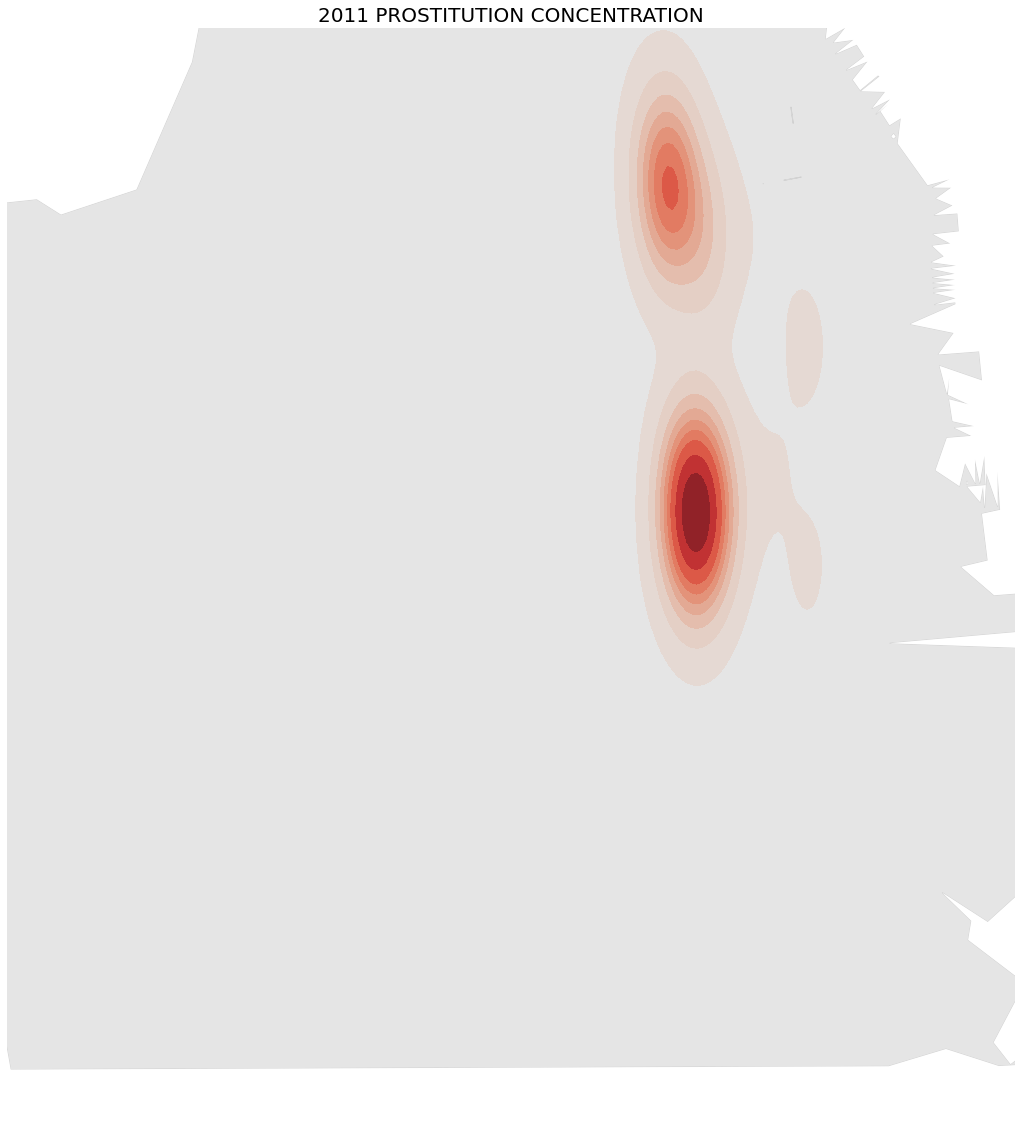

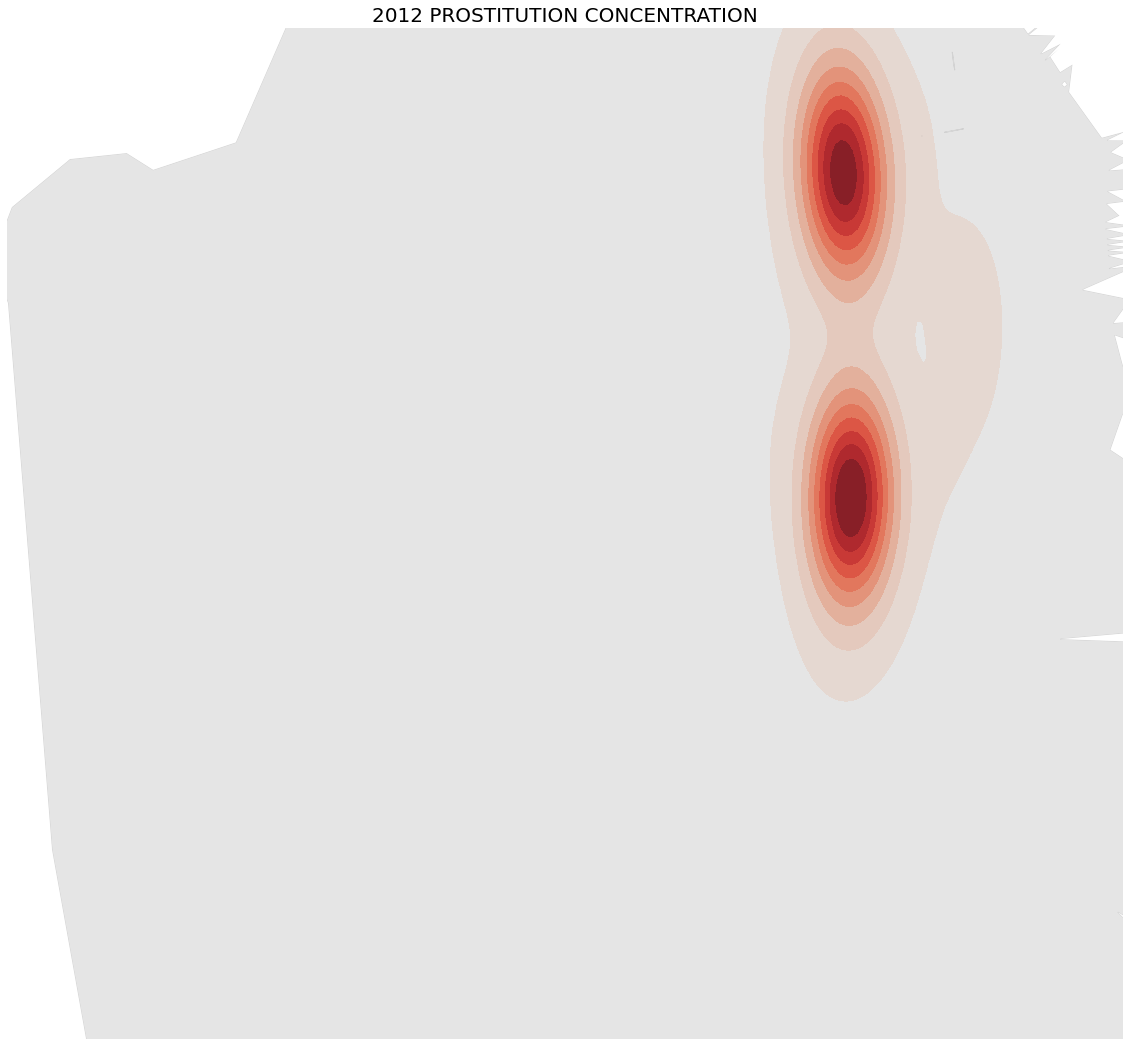

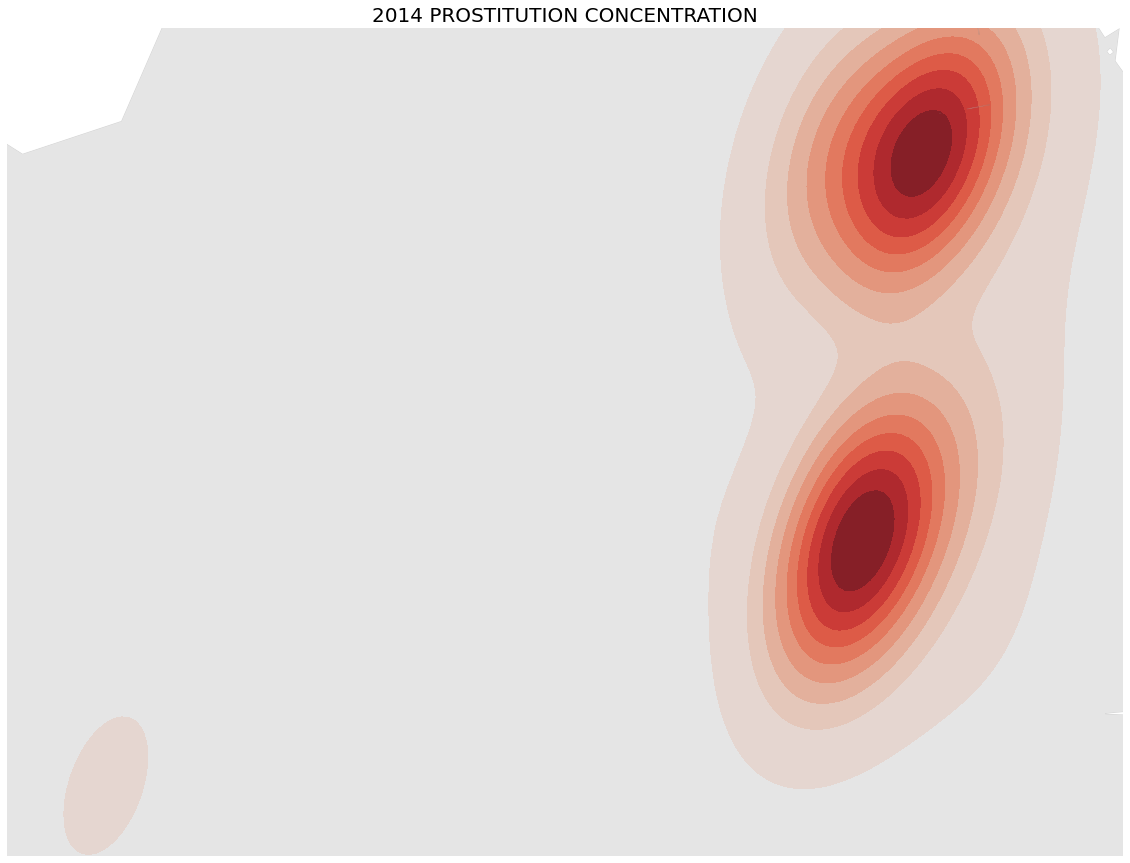

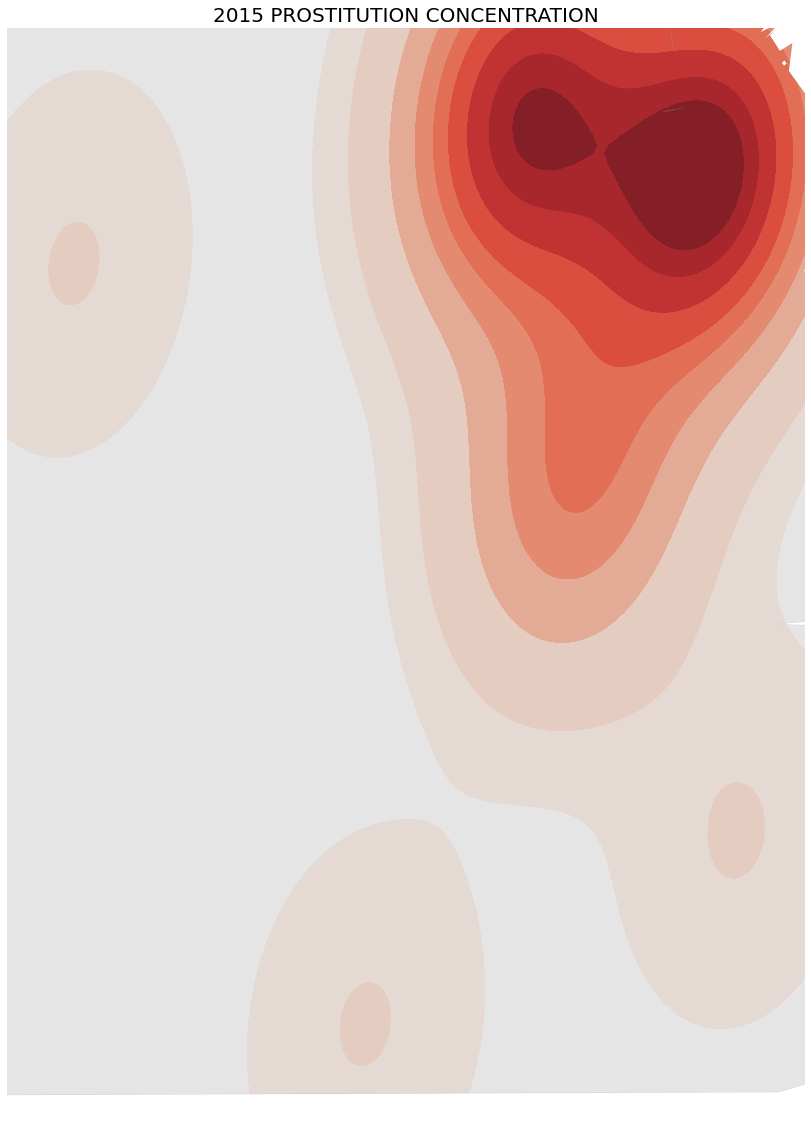

In [24]:
for year in df_target["Year"].unique():
    ax = gplt.polyplot(study_area,figsize = (20,20), projection=gcrs.AlbersEqualArea(), zorder=1,color = "grey",alpha = 0.2)
    ax.set_title(f"{year} PROSTITUTION CONCENTRATION",fontsize=20)
    gplt.kdeplot(df_target.loc[df_target["Year"] == year], cmap='Reds', shade=True, clip=study_area, ax=ax)
    
    plt.savefig(os.path.join(figures,"{}.jpg".format(year)))

C:\Users\eduar\.conda\envs\exp\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\eduar\.conda\envs\exp\lib\site-packages\seaborn\distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\eduar\.conda\envs\exp\lib\site-packages\cartopy\crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part

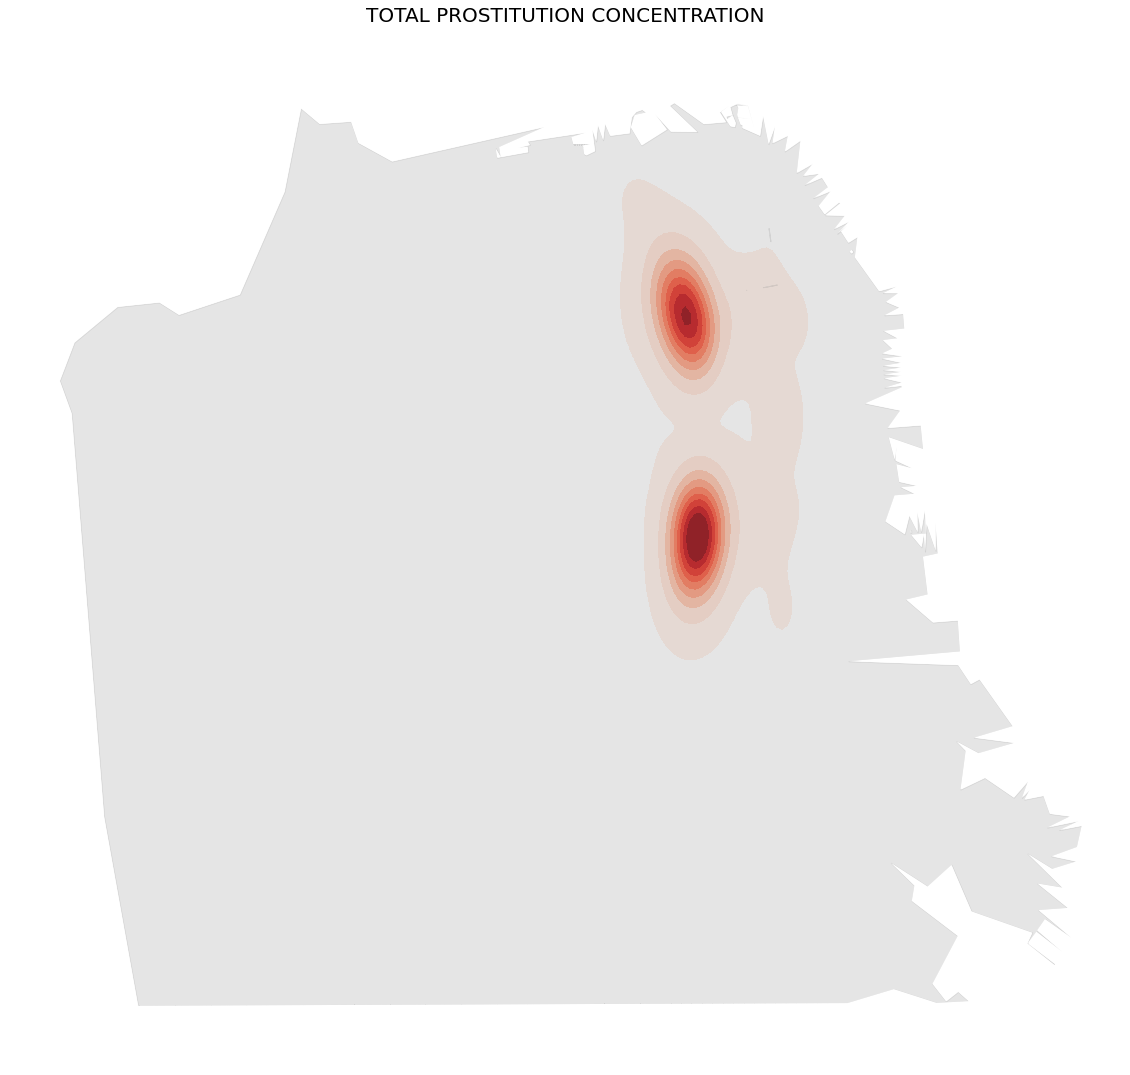

In [25]:
ax = gplt.polyplot(study_area,figsize = (20,20), projection=gcrs.AlbersEqualArea(), zorder=1,color = "grey",alpha = 0.2)
ax.set_title("TOTAL PROSTITUTION CONCENTRATION",fontsize=20)
gplt.kdeplot(df_target, cmap='Reds', shade=True, clip=study_area, ax=ax)

plt.savefig(os.path.join(figures,"Heatmap_total.jpg"))


Understanding the territories

In [26]:
#lets import a shapefile 
sf = gpd.read_file(os.path.join(infolder,"sf_shape.shp"))

In [27]:
gdf["other_crimes"] = gdf[target]
gdf.replace({"other_crimes":{0:1,1:0}},inplace = True)

In [28]:
#firstly i will group the crimes by 
grouped_target = gdf.groupby("name").sum().reset_index()
grouped_target = grouped_target[["name","other_crimes",target]]

grouped_target["total"] = grouped_target[target] + grouped_target["other_crimes"]
grouped_target["proportion"] = grouped_target[target]/grouped_target["total"]
grouped_target

name  other_crimes  PROSTITUTION  total  proportion
0                Alamo Square          1808             0   1808    0.000000
1                  Anza Vista          1781             0   1781    0.000000
2                Apparel City          1495             1   1496    0.000668
3    Aquatic Park / Ft. Mason          1385             1   1386    0.000722
4             Ashbury Heights           696             0    696    0.000000
..                        ...           ...           ...    ...         ...
112               West Portal          1595             2   1597    0.001252
113          Western Addition         12947             8  12955    0.000618
114        Westwood Highlands           144             0    144    0.000000
115             Westwood Park           858             0    858    0.000000
116        Yerba Buena Island          1129             2   1131    0.001768

[117 rows x 5 columns]

In [29]:
#Now i merged the grouped DF with the San Francisco Geodataframe
gdf_neigh = sf.merge(grouped_target,how="outer", left_on = "name", right_on = "name")
gdf_neigh

link  \
0    http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...   
1                                                 None   
2                    http://www.nps.gov/prsf/index.htm   
3                                                 None   
4    http://www.sfgate.com/neighborhoods/sf/innerri...   
..                                                 ...   
112  http://en.wikipedia.org/wiki/Corona_Heights,_S...   
113        http://en.wikipedia.org/wiki/Haight-Ashbury   
114  http://en.wikipedia.org/wiki/Eureka_Valley,_Sa...   
115  http://en.wikipedia.org/wiki/St._Francis_Wood,...   
116  http://en.wikipedia.org/wiki/Neighborhoods_in_...   

                       name     area  \
0                  Seacliff   461198   
1               Lake Street   383908   
2    Presidio National Park  6141300   
3          Presidio Terrace   328920   
4            Inner Richmond  2267095   
..                      ...      ...   
112          Corona Heights   284529   
113         Ashbury Heights   343814   
114           Eureka Valley   759104   
115        St. Francis Wood   433180   
116         Sherwood Forest   540027   

                                              geometry  other_crimes  \
0    POLYGON ((-122.49346 37.78352, -122.49373 37.7...           335   
1    POLYGON ((-122.48715 37.78379, -122.48729 37.7...           625   
2    POLYGON ((-122.47758 37.81099, -122.47712 37.8...            78   
3    POLYGON ((-122.47241 37.78735, -122.47100 37.7...           673   
4    POLYGON ((-122.47263 37.78631, -122.46683 37.7...          8712   
..                                                 ...           ...   
112  POLYGON ((-122.43519 37.76267, -122.43532 37.7...           822   
113  POLYGON ((-122.45196 37.76148, -122.45210 37.7...           696   
114  POLYGON ((-122.43734 37.76235, -122.43704 37.7...          2203   
115  POLYGON ((-122.47157 37.73471, -122.46831 37.7...           276   
116  POLYGON ((-122.45890 37.74054, -122.45877 37.7...           249   

     PROSTITUTION  total  proportion  
0               0    335    0.000000  
1               0    625    0.000000  
2               0     78    0.000000  
3               0    673    0.000000  
4               6   8718    0.000688  
..            ...    ...         ...  
112             0    822    0.000000  
113             0    696    0.000000  
114             0   2203    0.000000  
115             0    276    0.000000  
116             0    249    0.000000  

[117 rows x 8 columns]

Now i will calculate a simple crime rate to plot in a choropletic map. I will do that because in choropletic maps we can not use absolute numbers. This can cause a distortion.

In [30]:
gdf_neigh["density_othercrimes"] = gdf_neigh["other_crimes"]/gdf_neigh["area"]
gdf_neigh["density_target"] = gdf_neigh[target]/gdf_neigh["area"]
gdf_neigh["density_total"] = gdf_neigh["total"]/gdf_neigh["area"]
gdf_neigh["density_proportion"] = gdf_neigh["proportion"]/gdf_neigh["area"]

C:\Users\eduar\.conda\envs\exp\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\eduar\.conda\envs\exp\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)
C:\Users\eduar\.conda\envs\exp\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\eduar\.conda\envs\exp\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


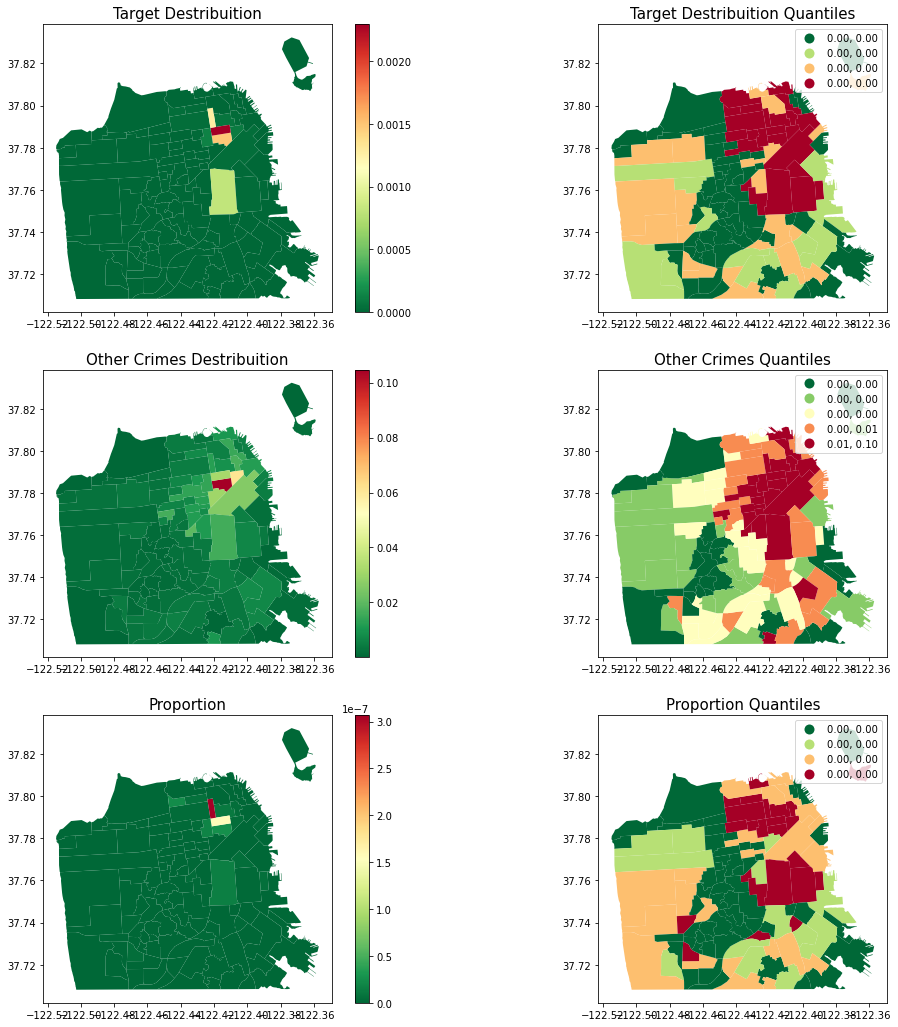

In [31]:

# Set up figure and axes
f, axs = plt.subplots(3,2, figsize=(18, 18))
axs = axs.flatten()

#Subplot 0                   
ax = axs[0]
gdf_neigh.plot(column="density_target", cmap = "RdYlGn_r", legend = True,ax=ax)
ax.set_title("Target Destribuition",fontsize=15)

#Subplot 1    
ax = axs[1]
gdf_neigh.plot(column="density_target", cmap = "RdYlGn_r", legend = True,scheme = "Quantiles",ax=ax)
ax.set_title("Target Destribuition Quantiles",fontsize=15)

#Subplot 2    
ax = axs[2]
gdf_neigh.plot(column="density_othercrimes", cmap = "RdYlGn_r", legend = True,ax=ax)
ax.set_title("Other Crimes Destribuition",fontsize=15)

#Subplot 3  
ax = axs[3]
gdf_neigh.plot(column="density_othercrimes", cmap = "RdYlGn_r", legend = True,scheme = "Quantiles",ax=ax)
ax.set_title("Other Crimes Quantiles",fontsize=15)

#Subplot 4
ax = axs[4]
gdf_neigh.plot(column="density_proportion", cmap = "RdYlGn_r", legend = True,ax=ax)
ax.set_title("Proportion",fontsize=15)

#Subplot 5
ax = axs[5]
gdf_neigh.plot(column="density_proportion", cmap = "RdYlGn_r", legend = True,scheme = "Quantiles",ax=ax)
ax.set_title("Proportion Quantiles",fontsize=15)

plt.savefig(os.path.join(figures,"Choropletic Maps.jpg"))

We can also create a cartogram with Geoplot

C:\Users\eduar\.conda\envs\exp\lib\site-packages\geoplot\geoplot.py:254: UserWarning: Please specify "legend_var" explicitly when both "hue" and "scale" are specified. Defaulting to "legend_var='hue'".
  warnings.warn(


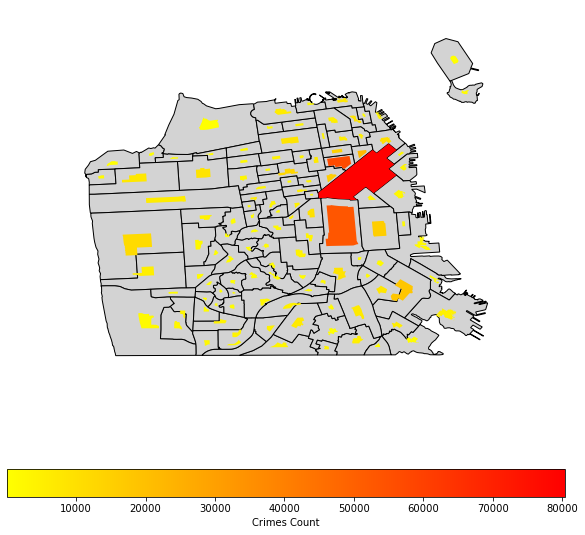

In [32]:


ax = gplt.cartogram(
    gdf_neigh, scale='total', limits=(0.2, 1),
    edgecolor='None', figsize=(10, 10),cmap='autumn_r',hue = "total",legend=True, legend_kwargs ={"label":"Crimes Count","orientation":"horizontal"}
)
gplt.polyplot(gdf_neigh, edgecolor='black', ax=ax,facecolor='lightgray')

plt.savefig(os.path.join(figures,"Cartogram_allcrimes.jpg"))

C:\Users\eduar\.conda\envs\exp\lib\site-packages\geoplot\geoplot.py:254: UserWarning: Please specify "legend_var" explicitly when both "hue" and "scale" are specified. Defaulting to "legend_var='hue'".
  warnings.warn(


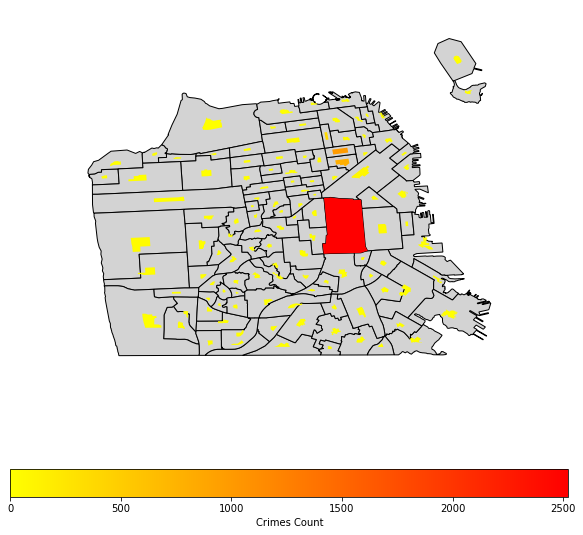

In [33]:


ax = gplt.cartogram(
    gdf_neigh, scale=target, limits=(0.2, 1),
    edgecolor='None', figsize=(10, 10),cmap='autumn_r',hue = target,legend=True, legend_kwargs ={"label":"Crimes Count","orientation":"horizontal"}
)
gplt.polyplot(gdf_neigh, edgecolor='black', ax=ax,facecolor='lightgray')

plt.savefig(os.path.join(figures,"Cartogram_target.jpg"))

CITAR O BOOK

In [34]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(gdf_neigh, k=8)
# Row-standardization
w.transform = 'R'

C:\Users\eduar\.conda\envs\exp\lib\site-packages\pysal\lib\weights\util.py:1028: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in iterable])


In [35]:
gdf_neigh['w_proportion'] = weights.spatial_lag.lag_spatial(w, gdf_neigh['proportion'])

In [36]:
gdf_neigh['proportion_std'] = ( gdf_neigh['proportion'] - gdf_neigh['proportion'].mean() )\
                    / gdf_neigh['proportion'].std()
gdf_neigh['w_proportion_std'] = ( gdf_neigh['w_proportion'] - gdf_neigh['proportion'].mean() )\
                    / gdf_neigh['proportion'].std()

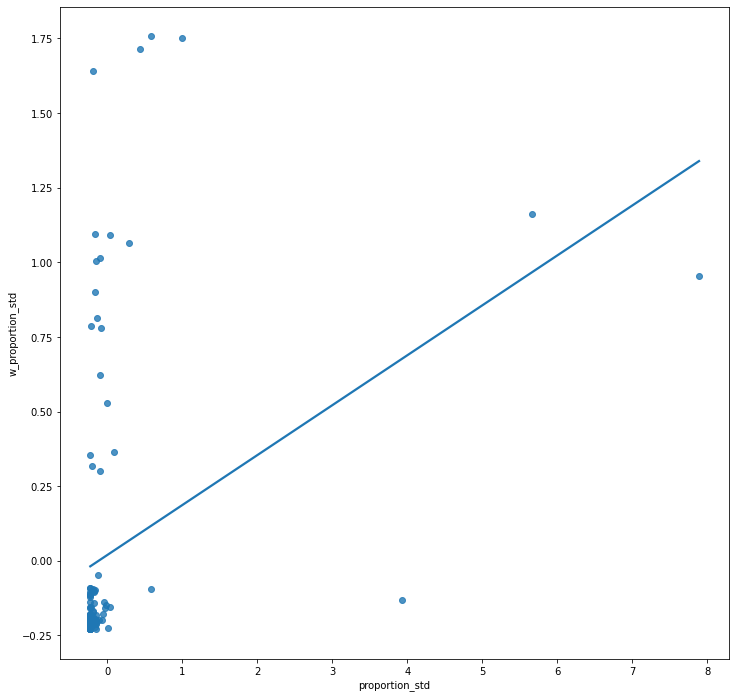

In [37]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))
# Plot values
sns.regplot(x='proportion_std', y='w_proportion_std', data=gdf_neigh, ci=None)
# Display
plt.show()

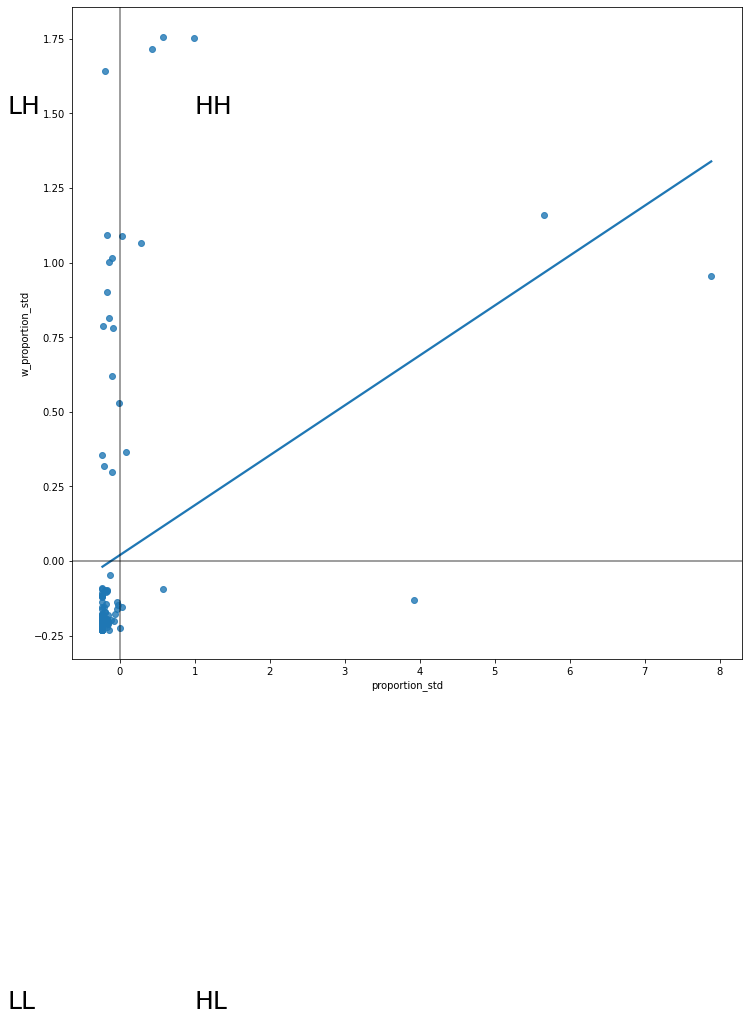

In [38]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))
# Plot values
sns.regplot(x='proportion_std', y='w_proportion_std', data=gdf_neigh, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(1, 1.5, "HH", fontsize=25)
plt.text(1, -1.5, "HL", fontsize=25)
plt.text(-1.5, 1.5, "LH", fontsize=25)
plt.text(-1.5, -1.5, "LL", fontsize=25)
# Display
plt.show()

In [39]:
lisa = esda.moran.Moran_Local(gdf_neigh['proportion'], w)

<AxesSubplot:ylabel='Density'>

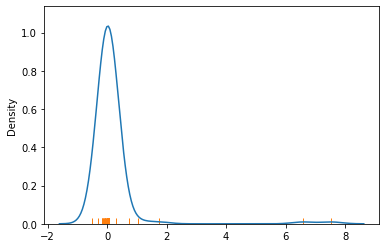

In [40]:
ax = sns.kdeplot(lisa.Is)
sns.rugplot(lisa.Is, ax=ax)

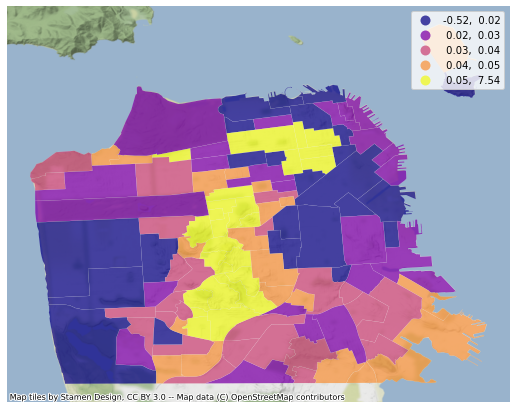

In [41]:
f, ax = plt.subplots(1, figsize=(9,9))
gdf_neigh['Is'] = lisa.Is
gdf_neigh.plot(column='Is', cmap='plasma', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);
contextily.add_basemap(ax, 
                       crs=gdf_neigh.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

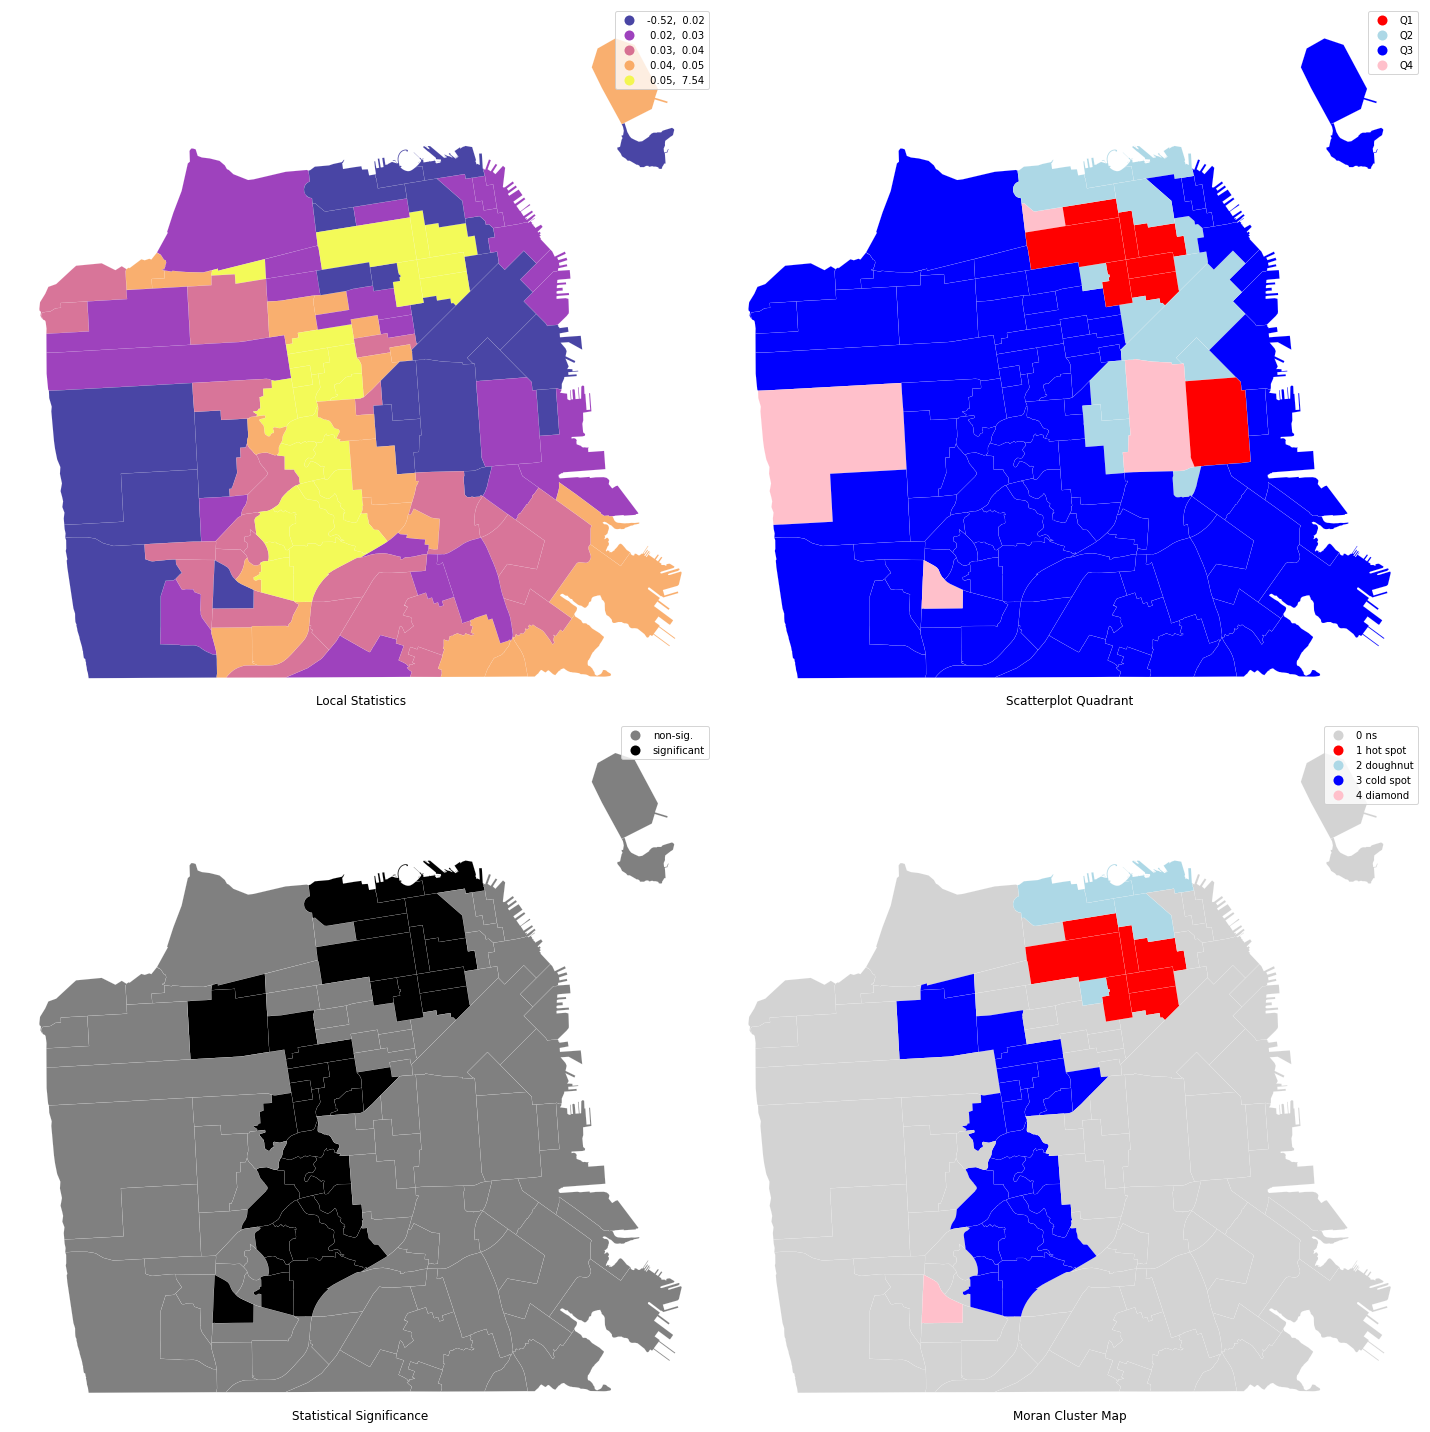

<Figure size 432x288 with 0 Axes>

In [42]:
from matplotlib import colors

# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
ax = axs[0]
gdf_neigh.plot(column='Is', cmap='plasma', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True, ax=ax)

                    # Subplot 2 #
ax = axs[1]
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels = [q_labels[i-1] for i in lisa.q]
hmap = colors.ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
gdf_neigh.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

                    # Subplot 3 #

ax = axs[2]
sig = 1 * (lisa.p_sim < 0.05)
hmap = colors.ListedColormap(['grey','black'])
labels = ['non-sig.', 'significant'] 
labels = [labels[i] for i in sig]
gdf_neigh.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

                       
                    # Subplot 4 #
ax = axs[3]
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])


gdf_neigh.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(['Local Statistics', 
                  'Scatterplot Quadrant', 
                  'Statistical Significance', 
                  'Moran Cluster Map'][i], y=0)

f.tight_layout()

# Display the figure
plt.show()

plt.savefig(os.path.join(figures,"spatial_statistics.jpg"))

In [43]:
counts = pd.value_counts(lisa.q)
counts

3    92
2    13
1     8
4     4
dtype: int64

In [44]:
sig = 1 * (lisa.p_sim < 0.05)
gdf_neigh['p-sim'] = lisa.p_sim
gdf_neigh['sig'] = sig
gdf_neigh[['sig','p-sim']].head()

sig  p-sim
0    0  0.077
1    0  0.116
2    0  0.436
3    1  0.014
4    1  0.017

In [45]:
gdf_neigh[['sig','p-sim']].tail()

sig  p-sim
112    1  0.040
113    1  0.006
114    0  0.111
115    0  0.295
116    1  0.023

In [46]:
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']

In [47]:
gdf_neigh['labels'] = labels
pd.value_counts(labels)

0 ns           82
3 cold spot    22
1 hot spot      7
2 doughnut      5
4 diamond       1
dtype: int64

In [48]:
coordinates = df_target[["X","Y"]].to_numpy()
labels = HDBSCAN(min_cluster_size=60).fit(coordinates).labels_
df_target["labels"] = labels

C:\Users\eduar\.conda\envs\exp\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


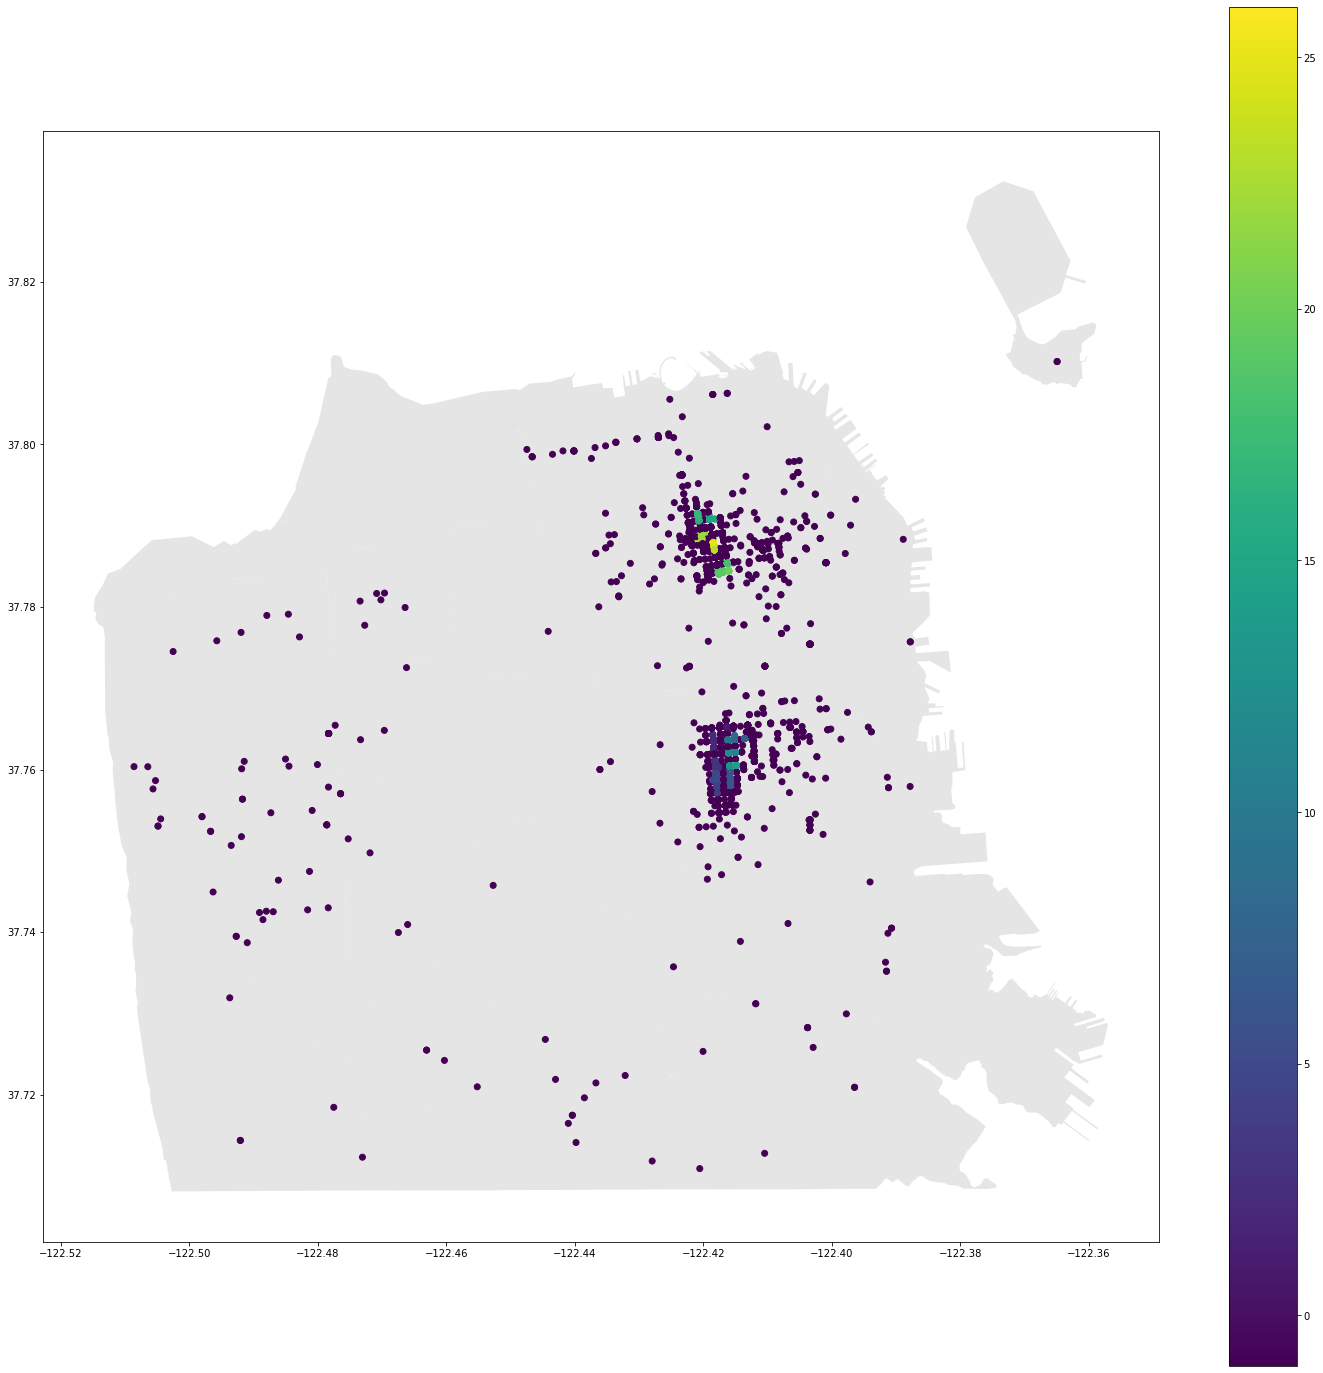

In [49]:
fig, ax = plt.subplots (figsize = (25,25))
sf.plot(ax = ax, alpha = 0.2, color = "grey")
df_target.plot(ax=ax,column = "labels",legend = True)

plt.savefig(os.path.join(figures,"Cluster.jpg"))

<AxesSubplot:>

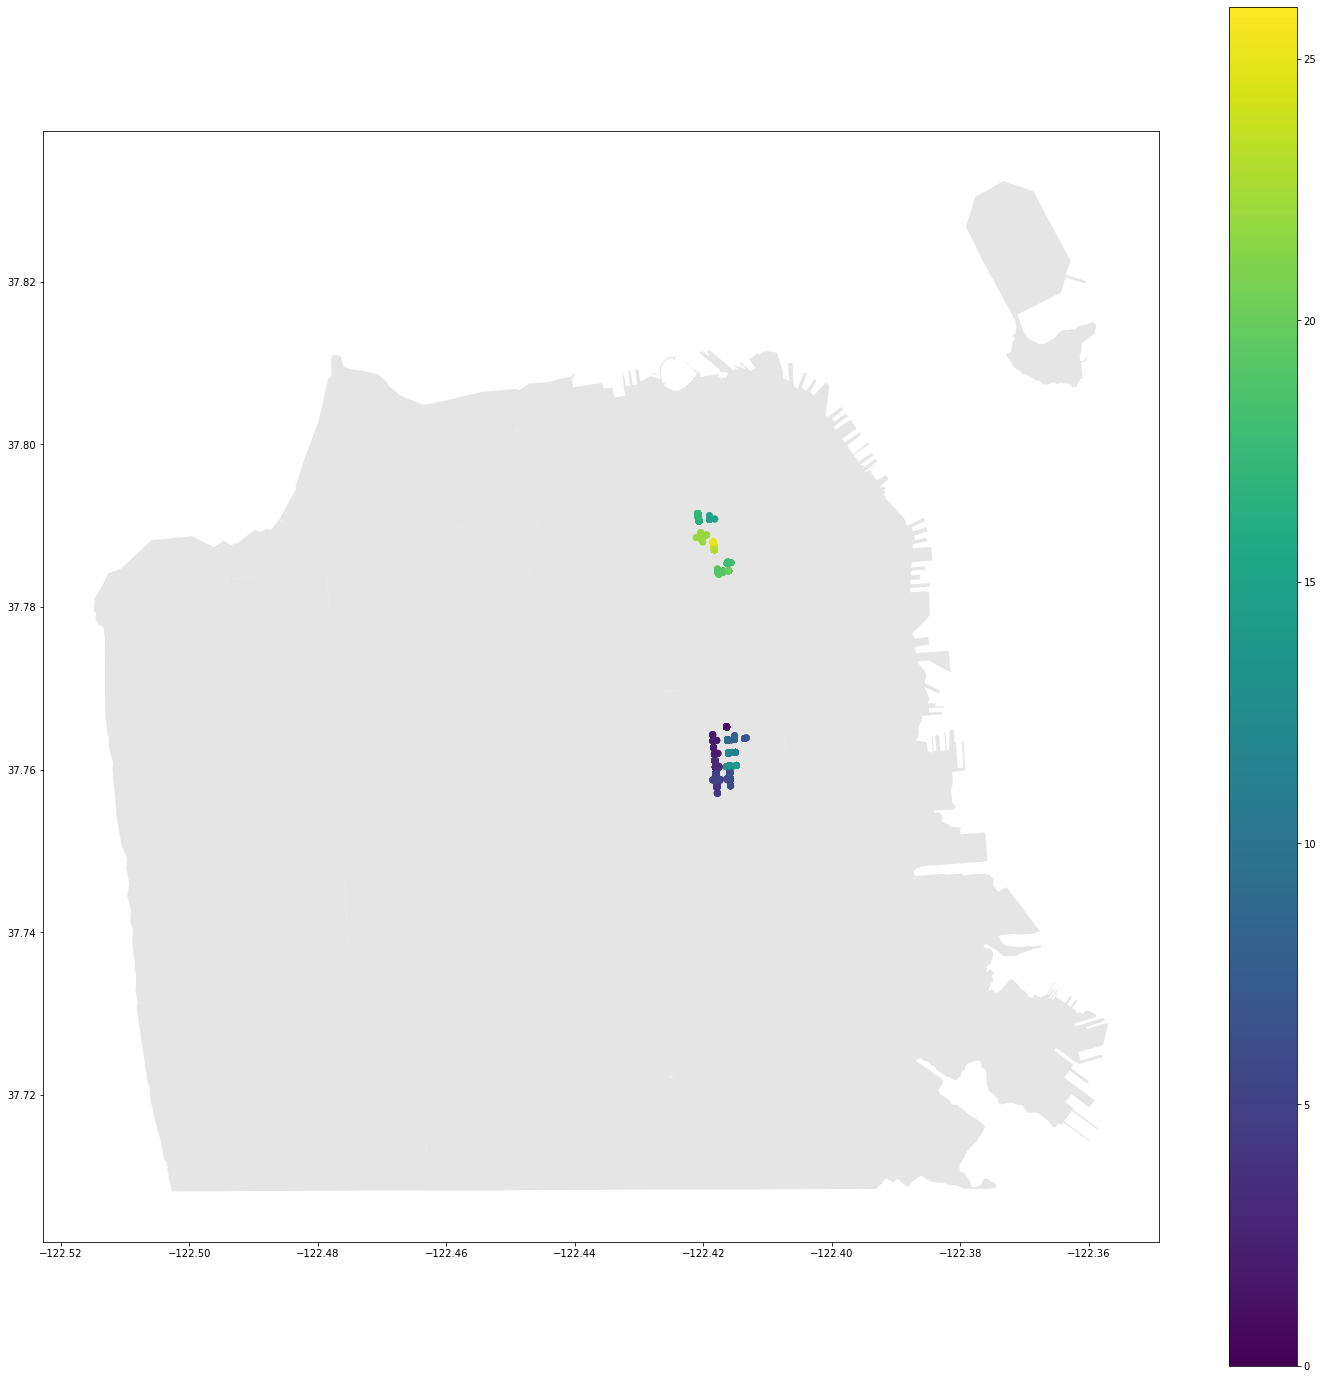

In [50]:
fig, ax = plt.subplots (figsize = (25,25))
sf.plot(ax = ax, alpha = 0.2, color = "grey")
df_target.loc[df_target["labels"] != -1].plot(ax=ax,column = "labels",legend = True)

In [51]:
labels

array([ 5,  2, -1, ..., -1, -1, -1], dtype=int64)

In [52]:
hulls = df_target[['geometry']].dissolve(by=labels).convex_hull

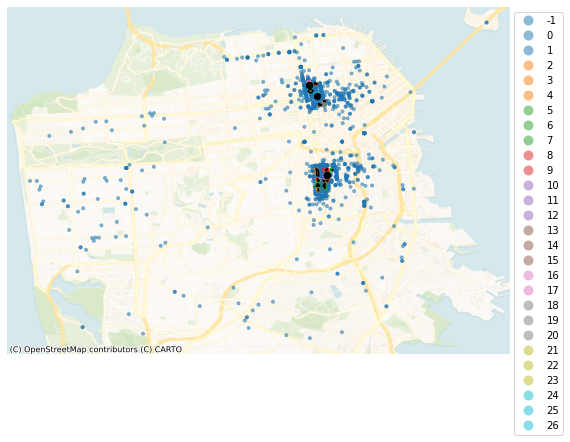

In [53]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot individual Airbnb locations
df_target.plot(
    # Colour by cluster label
    column=labels,
    # Consider label as categorical
    categorical=True,
    # Add 50% of transparency
    alpha=0.5,
    # Include legend
    legend=True,
    # Draw on axis `ax`
    ax=ax, 
    # Use circle as marker
    marker='.',
    # Position legend outside the map
    legend_kwds={'bbox_to_anchor': (1,1)}
)
# Plot convex hull polygons for each cluster label
# except that for -1 (observations classified as noise)
hulls[hulls.index != -1].boundary.plot(color='k', ax=ax)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=df_target.crs.to_string(), 
    source=contextily.providers.CartoDB.VoyagerNoLabels
)
# Remove axes
ax.set_axis_off();
plt.savefig(os.path.join(figures,"Cluster_Polygons.jpg"))

Saving our progress

In [54]:
gdf.to_csv(os.path.join(outfolder,"df_EDA.csv"),index = False)
#we also export the hulls and the lisa results to use it in the feature engineering step
gpd.GeoDataFrame(hulls).to_csv(os.path.join(outfolder,"hulls.csv"),index = False)
gdf_neigh.to_csv(os.path.join(outfolder,"neighbourhoods.csv"),index = False)
df_target.to_csv(os.path.join(outfolder,"df_target.csv"),index = False)
df_other_crimes.to_csv(os.path.join(outfolder,"df_othercrimes.csv"),index = False)